In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50, InceptionResNetV2, DenseNet201

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.options.display.float_format = "{:,.2f}".format

DATA_PATH = './data/'
MODEL_PATH = './model'

# DeepFashion: Versión reducida

En este notebook se realiza la comparativa entre un único modelo multietiqueta y un modelo compuesto por sub-modelos por tipo de atributo. 

Se emplea la versión reducida del conjunto de datos de DeepFashion. En análisis descriptivo de este conjunto de datos se realiza en un [Notebook anexo](./DeepFashion_VersionReducida_Analisis.ipynb). También se ha realizado [el mismo análisis](./DeepFashion_VersionCompleta_Analisis.ipynb) de la versión completa del dataset.

Para el particionado de datos en los conjuntos de entrenamiento, validación y test se emplean las particiones proporcionadas junto con el conjunto de datos. 

In [3]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

En primer lugar se crea una serie de estructuras de datos auxiliares para facilitar el trabajo con el dataset

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

In [5]:
# column_to_attr_name: Mapping número columna -> Nombre de atributo
# attr_type_to_columns: Mapping tipo de atributo - Lista de columnas de atributos de dicho tipo
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
# Listado con los nombre de los atributos
attributes = list(column_to_attr_name.values())

Extraemos las imágenes que forman parte de cada una de las paticiones, y las copiamos en un directorio con el nombre de la partición (test, val, train):

In [6]:
# Devuelve el listado de imágnes del fichero recibido como parámetro
def read_image_list(file_name):
    file_path = ANNO_FINE_PATH + '/' + file_name + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
# Devuelve el path de la partición a partir del nombre de la partición
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

# Creación de la estructura de datos necesaria para los generadores de aumentación de datos
def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            # Carga del listado de imágenes
            image_list = read_image_list(partition)
            # Copia
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [7]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes, que realizan las transformaciones de data augmentation de forma dinámica en cada epoch del entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [8]:
# Construcción del dataframe requerido para usar la función flow_from_dataframe
def build_iterator_dataframe(partition):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    print(partition_attribute_filepath)
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [9]:
SEED = 1
BATCH_SIZE = 4

# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train'),
        x_col="filename",
        y_col=attributes,
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val'),
        x_col="filename",
        y_col=attributes,
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test'),
        x_col="filename",
        y_col=attributes,        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

El siguiente código elige de forma aleatoria una imagen de la partición de test, y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

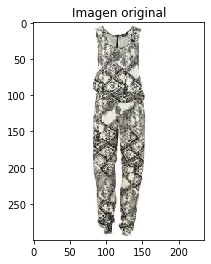

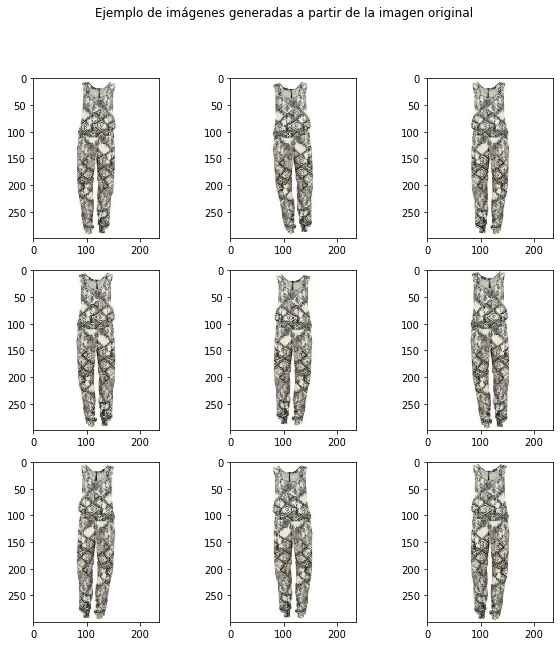

In [10]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 


In [11]:
# Definición de la función de loss empleada por defecto. 
# Detallado en la sección "Selección de función de loss"

import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [12]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model

def build_callbacks(model_name, model_id, store_model):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id), 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=weighted_binary_crossentropy
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode)
    
    
    
    # FIT
    # Dependiendo de la complejidad del modelo, se hace fit una única vez, o dos veces para ajustar primero las últimas capas
    # y posteriormente el resto
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    
    return (h.history['val_loss'], h.history['val_auc'])

In [13]:
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        plt.plot(v)
        legend.append(k)
    plt.title('Comparativa de ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [14]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [15]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_auc'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_auc) = train('baseline', it, store_model=False,
                                                           shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                                           fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_auc)]
    return results

In [16]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 2 days, 1:27:38.668186


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.05,0.15,2.50,constant,0.35,0.50
11,0.05,0.10,5,wrap,0.35,0.47
13,0.03,0.05,2.50,wrap,0.35,0.44
1,0.10,0.15,2.50,constant,0.35,0.39
18,0.10,0.10,7.50,constant,0.35,0.45
17,0.10,0.15,7.50,nearest,0.35,0.48
7,0.05,0.03,5,nearest,0.35,0.50
20,0.10,0.05,7.50,constant,0.35,0.38
23,0.10,0.05,5,constant,0.35,0.48
24,0.05,0.15,7.50,constant,0.35,0.52


Se establece los valores que minimizan el valor de loss sobre el conjunto de validación como los valores por defecto a emplear en la aumentación de datos, y serán los que se usarán para el entrenamiento de los modelos de los siguientes apartados. 

### 4.3 Selección de función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones, tal y como se comenta en [aquí](https://stackoverflow.com/questions/50686217/keras-how-is-accuracy-calculated-for-multi-label-classification). En el caso de este dataset existen 26 clases, y cada observación está asociada a 6 valores positivos y a 20 negativos. Este alto número de valores negativos hace que se obtenga siempre un valor alto de accuracy, por lo que se ha optado por emplear el área bajo la curva ROC (AUC) puesto que se considera que esta métrica, al estar basada en la relación entre sensibilidad y especificidadad, se ajusta más al problema en cuestión. 

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu). El código se ha definido en el apartado anterior. 

Se entrena el modelo baseline empleando las dos funciones de loss, y se establece la comparativa.

In [37]:
RESET = False
if(RESET):
    %cache -r res_binary_crossentropy
    %cache -r res_weighed_crossentropy

%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy, store_model=False)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy, store_model=False)

Resetting cached values for res_binary_crossentropy
Resetting cached values for res_weighed_crossentropy
Creating new value for variable 'res_binary_crossentropy'
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 35s 702ms/step - loss: 0.6565 - auc: 0.6694 - val_loss: 0.6019 - val_auc: 0.7512
Epoch 2/100
50/50 [==============================] - 23s 460ms/step - loss: 0.5250 - auc: 0.7643 - val_loss: 0.4465 - val_auc: 0.7584
Epoch 3/100
50/50 [==============================] - 23s 461ms/step - loss: 0.4279 - auc: 0.7610 - val_loss: 0.4007 - val_auc: 0.7628
Epoch 4/100
50/50 [==============================] - 23s 461ms/step - loss: 0.4039 - auc: 0.7668 - val_loss: 0.3781 - val_auc: 0.7732
Epoch 5/100
50/50 [==============================] - 23s 461ms/step - loss: 0.4057 - auc: 0.7782 - val_loss: 0.3710 - val_auc: 0.7811
Epoch

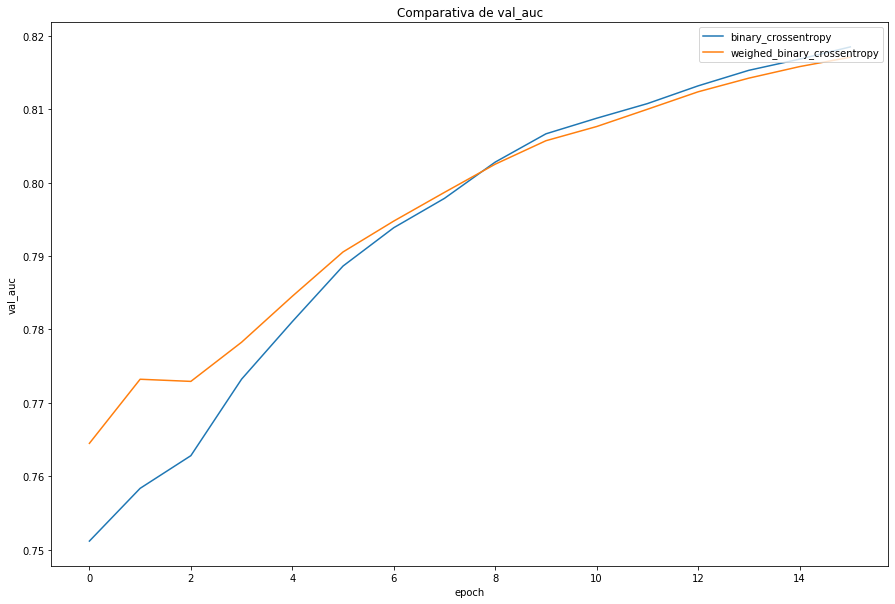

Max. val_auc binary_crossentropy: 0.8184903860092163
Max. val_auc weighed_binary_crossentropy:0.8170831799507141


In [38]:
results = {'binary_crossentropy' : res_binary_crossentropy[1], 'weighed_binary_crossentropy' : res_weighed_crossentropy[1]}
plot(results, metric='val_auc')

print('Max. val_auc binary_crossentropy: {}'.format(max(res_binary_crossentropy[1])))
print('Max. val_auc weighed_binary_crossentropy:{}'.format(max(res_weighed_crossentropy[1])))

A partir de la gráfica anterior se puede comprobar que no existe apenas diferencia entre ambas métricas. Se empleará weighed_binary_crossentropy. Si bien para el dataset reducido puede que no tenga mucha diferencia, es posible que sí la tenga cuando se repita el mismo análisis con el dataset completo en el que los datos son mucho más disperos, y la proporción de 0s es muy superior a la de 1s. 

## 5. Entrenamiento

En este apartado se probarán varias arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten inicializar los valores a pesos entrenandos sobre ImageNet, por lo que permite beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

El entrenamiento se realiza en dos pasos:
1. Se congelan todas las capas del modelo pre-entrenado para entrenar únicamente las capas densas añadidas en la parte final de la red.
2. Se descongela un porcentaje de las últimas capas del modelo pre-entrenado y se repite el entrenamiento.

Todos los modelos entrenados se persisten junto a un ID para poder ser recuperados posteriormente en el apartado de evaluación. 

Para cada tipo de modelo se realiza un random search para encontrar los valores óptimos de los hiperparámetros. En todos ellos se emplea la sigmoid como función de activación en la capa de salida para poder obtener un valor entre 0 y 1 para todas las etiquetas. 

Los hiperparámetros que se prueban son:
* Tipo de poling: avg, max o sin pooling.
* Número de neurnas en la última capa densa: entre 128 y 512
* Porcentaje de capas iniciales a congelar: entre 50 y 80%. 

Se emplea Adam como optimizador para todos los modelos. No se ha hecho una comparativa con otros optimizadores. 

In [19]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_InceptionResNetV2(input_shape, params):
    base_model = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_DenseNet201(input_shape, params):
    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


A continuación se define el código para realizar un random search de los parámetros. Se realizará una exploración de N (20) combinaciones por cada arquitectura probada.

In [20]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss','val_auc', 'time'])
    for i in range(0, N):
        try:
            # Random search de los parámetros
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            print('Evaluation #{}'.format(i))
            start = time.time()
            
            # Llamada a la función de entrenamiento definida en apartados anteriores
            (val_loss, val_auc) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params)
            end = time.time() - start
            
            # Acumulación de los resultados
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_auc, end]
        except Exception as e:
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

Lanzamos la búsqueda:

In [21]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16
    %cache -r results_inceptionResNetV2
    %cache -r results_densenet201    

%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')
%cache results_inceptionResNetV2 = try_pretrained_model('InceptionResNetV2')
%cache results_densenet201 = try_pretrained_model('DenseNet201')

Resetting cached values for results_inceptionV3
Resetting cached values for results_resnet50
Resetting cached values for results_vgg16
Resetting cached values for results_inceptionResNetV2
Resetting cached values for results_densenet201
Creating new value for variable 'results_inceptionV3'
Evaluation #0
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 287ms/step - loss: 1.4235 - auc: 0.7892 - val_loss: 1.7433 - val_auc: 0.8177
Epoch 2/100
50/50 [==============================] - 6s 127ms/step - loss: 1.2787 - auc: 0.8214 - val_loss: 1.3134 - val_auc: 0.8215
Epoch 3/100
50/50 [==============================] - 6s 124ms/step - loss: 1.2584 - auc: 0.8237 - val_loss: 1.3254 - val_auc: 0.8263
Epoch 4/100
50/50 [==============================] - 6s 128ms/step - loss: 1.2780 - auc: 0.8269 - val_loss: 1.1638 - val_auc: 0.8306


50/50 [==============================] - 10s 193ms/step - loss: 1.0443 - auc: 0.8362 - val_loss: 0.9835 - val_auc: 0.8375

Epoch 00021: val_loss improved from 0.99959 to 0.98348, saving model to ./model/InceptionV3_0.h5
Epoch 22/100
50/50 [==============================] - 10s 194ms/step - loss: 1.1031 - auc: 0.8386 - val_loss: 1.1271 - val_auc: 0.8396

Epoch 00022: val_loss did not improve from 0.98348
Epoch 23/100
50/50 [==============================] - 10s 194ms/step - loss: 1.0330 - auc: 0.8407 - val_loss: 1.1699 - val_auc: 0.8416

Epoch 00023: val_loss did not improve from 0.98348
Epoch 24/100
50/50 [==============================] - 10s 193ms/step - loss: 1.0348 - auc: 0.8424 - val_loss: 1.0653 - val_auc: 0.8433

Epoch 00024: val_loss did not improve from 0.98348
Epoch 25/100
50/50 [==============================] - 10s 193ms/step - loss: 1.0481 - auc: 0.8442 - val_loss: 1.1157 - val_auc: 0.8448

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

E

50/50 [==============================] - 10s 208ms/step - loss: 1.7111 - auc: 0.7755 - val_loss: 1.7136 - val_auc: 0.7776

Epoch 00010: val_loss improved from 1.72808 to 1.71357, saving model to ./model/InceptionV3_1.h5
Epoch 11/100
50/50 [==============================] - 10s 208ms/step - loss: 1.6975 - auc: 0.7792 - val_loss: 1.6808 - val_auc: 0.7808

Epoch 00011: val_loss improved from 1.71357 to 1.68080, saving model to ./model/InceptionV3_1.h5
Epoch 12/100
50/50 [==============================] - 10s 208ms/step - loss: 1.6902 - auc: 0.7820 - val_loss: 1.6568 - val_auc: 0.7829

Epoch 00012: val_loss improved from 1.68080 to 1.65684, saving model to ./model/InceptionV3_1.h5
Epoch 13/100
50/50 [==============================] - 10s 206ms/step - loss: 1.6533 - auc: 0.7843 - val_loss: 1.6243 - val_auc: 0.7853

Epoch 00013: val_loss improved from 1.65684 to 1.62428, saving model to ./model/InceptionV3_1.h5
Epoch 14/100
50/50 [==============================] - 10s 208ms/step - loss: 1.63

./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 240ms/step - loss: 9.7817 - auc: 0.6673 - val_loss: 10.7827 - val_auc: 0.6791
Epoch 2/100
50/50 [==============================] - 7s 135ms/step - loss: 10.2374 - auc: 0.6827 - val_loss: 10.8152 - val_auc: 0.6828
Epoch 3/100
50/50 [==============================] - 7s 133ms/step - loss: 10.3568 - auc: 0.6829 - val_loss: 10.1950 - val_auc: 0.6807
Epoch 4/100
50/50 [==============================] - 7s 133ms/step - loss: 9.6698 - auc: 0.6797 - val_loss: 9.7253 - val_auc: 0.6791
Epoch 5/100
50/50 [==============================] - 7s 139ms/step - loss: 9.9777 - auc: 0.6781 - val_loss: 9.9637 - val_auc: 0.6794
Epoch 6/100
50/50 [==============================] - 7s 134ms/step - loss: 10.1510 - auc: 0.6805 - val_loss: 10.1766 - val_auc: 0.6815
Epoch 7/100
50/50 [=============

50/50 [==============================] - 9s 180ms/step - loss: 4.4578 - auc: 0.6857 - val_loss: 10.5961 - val_auc: 0.6861

Epoch 00029: val_loss did not improve from 5.66647
Epoch 30/100
50/50 [==============================] - 9s 180ms/step - loss: 4.4120 - auc: 0.6864 - val_loss: 7.9922 - val_auc: 0.6867

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00030: val_loss did not improve from 5.66647
Epoch 00030: early stopping
Evaluation #3
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 234ms/step - loss: 2.5193 - auc: 0.7402 - val_loss: 2.1346 - val_auc: 0.7584
Epoch 2/100
50/50 [==============================] - 6s 123ms/step - loss: 1.4296 - auc: 0.7641 - val_loss: 1.3328 - val_auc: 0.7754
Epoch 3/100
50/50 [==============================] - 6s 127ms/step - loss: 1.3843 - auc

50/50 [==============================] - 6s 124ms/step - loss: 1.2069 - auc: 0.8288 - val_loss: 1.1934 - val_auc: 0.8299
Epoch 14/100
50/50 [==============================] - 6s 128ms/step - loss: 1.1985 - auc: 0.8309 - val_loss: 1.1358 - val_auc: 0.8318
Epoch 15/100
50/50 [==============================] - 7s 131ms/step - loss: 1.2608 - auc: 0.8325 - val_loss: 1.1965 - val_auc: 0.8331
Epoch 16/100
50/50 [==============================] - 6s 128ms/step - loss: 1.2333 - auc: 0.8335 - val_loss: 1.1559 - val_auc: 0.8345
Epoch 17/100
50/50 [==============================] - 6s 124ms/step - loss: 1.2469 - auc: 0.8351 - val_loss: 1.2312 - val_auc: 0.8355
Epoch 18/100
50/50 [==============================] - 6s 126ms/step - loss: 1.1523 - auc: 0.8361 - val_loss: 1.2135 - val_auc: 0.8370

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 19/100
50/50 [==============================] - 6s 121ms/step - loss: 1.1692 - auc: 0.8377 - val_loss: 1.1166 - val_auc: 

50/50 [==============================] - 9s 173ms/step - loss: 1.1133 - auc: 0.8454 - val_loss: 1.2262 - val_auc: 0.8459

Epoch 00024: val_loss did not improve from 1.09166
Epoch 25/100
50/50 [==============================] - 9s 173ms/step - loss: 1.1456 - auc: 0.8463 - val_loss: 1.1885 - val_auc: 0.8467

Epoch 00025: val_loss did not improve from 1.09166
Epoch 26/100
50/50 [==============================] - 9s 171ms/step - loss: 1.1713 - auc: 0.8471 - val_loss: 1.2139 - val_auc: 0.8475

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00026: val_loss did not improve from 1.09166
Epoch 00026: early stopping
Evaluation #5
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 242ms/step - loss: 8.4209 - auc: 0.6955 - val_loss: 10.5693 - val_auc: 0.7113
Epoch 2/100
50/50 [===============


Epoch 00004: val_loss did not improve from 3.17146
Epoch 5/100
50/50 [==============================] - 10s 210ms/step - loss: 1.2884 - auc: 0.7516 - val_loss: 9.1121 - val_auc: 0.7458

Epoch 00005: val_loss did not improve from 3.17146
Epoch 6/100
50/50 [==============================] - 10s 209ms/step - loss: 1.2040 - auc: 0.7420 - val_loss: 1.5954 - val_auc: 0.7484

Epoch 00006: val_loss improved from 3.17146 to 1.59543, saving model to ./model/InceptionV3_6.h5
Epoch 7/100
50/50 [==============================] - 10s 208ms/step - loss: 1.2671 - auc: 0.7530 - val_loss: 1.3389 - val_auc: 0.7554

Epoch 00007: val_loss improved from 1.59543 to 1.33892, saving model to ./model/InceptionV3_6.h5
Epoch 8/100
50/50 [==============================] - 11s 210ms/step - loss: 1.1826 - auc: 0.7580 - val_loss: 2.6754 - val_auc: 0.7593

Epoch 00008: val_loss did not improve from 1.33892
Epoch 9/100
50/50 [==============================] - 10s 210ms/step - loss: 1.2055 - auc: 0.7601 - val_loss: 7.2

50/50 [==============================] - 6s 125ms/step - loss: 1.0724 - auc: 0.8616 - val_loss: 1.2016 - val_auc: 0.8622
Epoch 23/100
50/50 [==============================] - 6s 125ms/step - loss: 1.1398 - auc: 0.8625 - val_loss: 1.1928 - val_auc: 0.8629

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 24/100
50/50 [==============================] - 6s 123ms/step - loss: 1.1163 - auc: 0.8632 - val_loss: 1.3062 - val_auc: 0.8637
Epoch 25/100
50/50 [==============================] - 6s 123ms/step - loss: 1.1300 - auc: 0.8639 - val_loss: 1.1399 - val_auc: 0.8642
Epoch 26/100
50/50 [==============================] - 6s 121ms/step - loss: 1.0863 - auc: 0.8646 - val_loss: 1.0687 - val_auc: 0.8648
Epoch 27/100
50/50 [==============================] - 6s 126ms/step - loss: 1.1328 - auc: 0.8649 - val_loss: 1.1346 - val_auc: 0.8653
Epoch 28/100
50/50 [==============================] - 7s 131ms/step - loss: 1.1463 - auc: 0.8655 - val_loss: 1.0271 - val_auc: 

50/50 [==============================] - 11s 211ms/step - loss: 1.0142 - auc: 0.8651 - val_loss: 1.1723 - val_auc: 0.8658

Epoch 00027: val_loss did not improve from 0.96768
Epoch 28/100
50/50 [==============================] - 11s 211ms/step - loss: 1.0033 - auc: 0.8662 - val_loss: 1.0455 - val_auc: 0.8669

Epoch 00028: val_loss did not improve from 0.96768
Epoch 29/100
50/50 [==============================] - 11s 211ms/step - loss: 1.0688 - auc: 0.8673 - val_loss: 0.9724 - val_auc: 0.8678

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00029: val_loss did not improve from 0.96768
Epoch 00029: early stopping
Evaluation #8
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 239ms/step - loss: 2.7612 - auc: 0.7260 - val_loss: 2.7895 - val_auc: 0.7477
Epoch 2/100
50/50 [=============

Epoch 24/100
50/50 [==============================] - 10s 193ms/step - loss: 1.1135 - auc: 0.8437 - val_loss: 1.0949 - val_auc: 0.8444

Epoch 00024: val_loss did not improve from 1.03308
Epoch 25/100
50/50 [==============================] - 10s 193ms/step - loss: 1.1495 - auc: 0.8450 - val_loss: 1.1519 - val_auc: 0.8457

Epoch 00025: val_loss did not improve from 1.03308
Epoch 26/100
50/50 [==============================] - 10s 192ms/step - loss: 1.0874 - auc: 0.8462 - val_loss: 1.0483 - val_auc: 0.8468

Epoch 00026: val_loss did not improve from 1.03308
Epoch 27/100
50/50 [==============================] - 10s 195ms/step - loss: 1.1247 - auc: 0.8474 - val_loss: 1.0040 - val_auc: 0.8480

Epoch 00027: val_loss improved from 1.03308 to 1.00403, saving model to ./model/InceptionV3_8.h5
Epoch 28/100
50/50 [==============================] - 10s 194ms/step - loss: 1.0816 - auc: 0.8485 - val_loss: 1.1826 - val_auc: 0.8491

Epoch 00028: val_loss did not improve from 1.00403
Epoch 29/100
50/50 

50/50 [==============================] - 6s 124ms/step - loss: 1.3231 - auc: 0.8170 - val_loss: 1.3240 - val_auc: 0.8157
Epoch 3/100
50/50 [==============================] - 7s 143ms/step - loss: 1.2677 - auc: 0.8178 - val_loss: 1.4411 - val_auc: 0.8204
Epoch 4/100
50/50 [==============================] - 6s 126ms/step - loss: 1.2512 - auc: 0.8221 - val_loss: 1.3710 - val_auc: 0.8251
Epoch 5/100
50/50 [==============================] - 6s 125ms/step - loss: 1.2326 - auc: 0.8272 - val_loss: 1.3672 - val_auc: 0.8279
Epoch 6/100
50/50 [==============================] - 6s 128ms/step - loss: 1.1801 - auc: 0.8292 - val_loss: 1.4725 - val_auc: 0.8317

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
50/50 [==============================] - 6s 124ms/step - loss: 1.2054 - auc: 0.8333 - val_loss: 1.2967 - val_auc: 0.8349
Epoch 8/100
50/50 [==============================] - 6s 125ms/step - loss: 1.1438 - auc: 0.8367 - val_loss: 1.3062 - val_auc: 0.8383

Epoch 6/100
50/50 [==============================] - 6s 129ms/step - loss: 1.2451 - auc: 0.8036 - val_loss: 1.4252 - val_auc: 0.8072
Epoch 7/100
50/50 [==============================] - 6s 127ms/step - loss: 1.2762 - auc: 0.8091 - val_loss: 1.2970 - val_auc: 0.8115
Epoch 8/100
50/50 [==============================] - 6s 129ms/step - loss: 1.3034 - auc: 0.8128 - val_loss: 1.3666 - val_auc: 0.8141

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/100
50/50 [==============================] - 6s 121ms/step - loss: 1.2314 - auc: 0.8153 - val_loss: 1.3028 - val_auc: 0.8175
Epoch 10/100
50/50 [==============================] - 6s 126ms/step - loss: 1.2431 - auc: 0.8192 - val_loss: 1.1500 - val_auc: 0.8206
Epoch 11/100
50/50 [==============================] - 6s 129ms/step - loss: 1.2157 - auc: 0.8216 - val_loss: 1.2779 - val_auc: 0.8230
Epoch 12/100
50/50 [==============================] - 6s 127ms/step - loss: 1.2100 - auc: 0.8242 - val_loss: 1.1950 - 


Epoch 00030: val_loss did not improve from 0.93328
Epoch 31/100
50/50 [==============================] - 10s 195ms/step - loss: 1.1192 - auc: 0.8567 - val_loss: 1.0041 - val_auc: 0.8572

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00031: val_loss did not improve from 0.93328
Epoch 32/100
50/50 [==============================] - 10s 191ms/step - loss: 1.0835 - auc: 0.8577 - val_loss: 1.0372 - val_auc: 0.8581

Epoch 00032: val_loss did not improve from 0.93328
Epoch 33/100
50/50 [==============================] - 10s 193ms/step - loss: 1.0725 - auc: 0.8585 - val_loss: 1.1385 - val_auc: 0.8590

Epoch 00033: val_loss did not improve from 0.93328
Epoch 34/100
50/50 [==============================] - 10s 194ms/step - loss: 1.0401 - auc: 0.8595 - val_loss: 1.0662 - val_auc: 0.8600

Epoch 00034: val_loss did not improve from 0.93328
Epoch 35/100
50/50 [==============================] - 10s 193ms/step - loss: 1.0907 - auc: 0.8605 - val_loss: 1.2942 -

50/50 [==============================] - 9s 174ms/step - loss: 1.1746 - auc: 0.8176 - val_loss: 1.1952 - val_auc: 0.8192

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_loss did not improve from 1.16366
Epoch 11/100
50/50 [==============================] - 9s 174ms/step - loss: 1.1007 - auc: 0.8210 - val_loss: 1.1114 - val_auc: 0.8233

Epoch 00011: val_loss improved from 1.16366 to 1.11140, saving model to ./model/InceptionV3_12.h5
Epoch 12/100
50/50 [==============================] - 9s 174ms/step - loss: 1.0825 - auc: 0.8254 - val_loss: 1.0618 - val_auc: 0.8276

Epoch 00012: val_loss improved from 1.11140 to 1.06183, saving model to ./model/InceptionV3_12.h5
Epoch 13/100
50/50 [==============================] - 9s 172ms/step - loss: 1.0584 - auc: 0.8297 - val_loss: 0.9740 - val_auc: 0.8322

Epoch 00013: val_loss improved from 1.06183 to 0.97398, saving model to ./model/InceptionV3_12.h5
Epoch 14/100
50/50 [==========================

50/50 [==============================] - 8s 154ms/step - loss: 1.0714 - auc: 0.8573 - val_loss: 1.2524 - val_auc: 0.8584

Epoch 00011: val_loss did not improve from 1.22017
Epoch 12/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0711 - auc: 0.8593 - val_loss: 1.1989 - val_auc: 0.8604

Epoch 00012: val_loss improved from 1.22017 to 1.19888, saving model to ./model/InceptionV3_13.h5
Epoch 13/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0404 - auc: 0.8613 - val_loss: 1.1815 - val_auc: 0.8625

Epoch 00013: val_loss improved from 1.19888 to 1.18150, saving model to ./model/InceptionV3_13.h5
Epoch 14/100
50/50 [==============================] - 8s 154ms/step - loss: 1.0545 - auc: 0.8635 - val_loss: 1.2384 - val_auc: 0.8645

Epoch 00014: val_loss did not improve from 1.18150
Epoch 15/100
50/50 [==============================] - 8s 154ms/step - loss: 1.0707 - auc: 0.8652 - val_loss: 1.2960 - val_auc: 0.8663

Epoch 00015: val_loss did not improve fr

Epoch 3/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2337 - auc: 0.7613 - val_loss: 1.4392 - val_auc: 0.7731

Epoch 00003: val_loss improved from 1.95305 to 1.43917, saving model to ./model/InceptionV3_14.h5
Epoch 4/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3085 - auc: 0.7791 - val_loss: 1.2532 - val_auc: 0.7853

Epoch 00004: val_loss improved from 1.43917 to 1.25322, saving model to ./model/InceptionV3_14.h5
Epoch 5/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2341 - auc: 0.7898 - val_loss: 1.2520 - val_auc: 0.7945

Epoch 00005: val_loss improved from 1.25322 to 1.25198, saving model to ./model/InceptionV3_14.h5
Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2695 - auc: 0.7979 - val_loss: 1.2192 - val_auc: 0.8012

Epoch 00006: val_loss improved from 1.25198 to 1.21921, saving model to ./model/InceptionV3_14.h5
Epoch 7/100
50/50 [==============================] - 11s 226ms/step 

Epoch 1/100
50/50 [==============================] - 17s 334ms/step - loss: 6.4075 - auc: 0.6739 - val_loss: 10.8601 - val_auc: 0.6854

Epoch 00001: val_loss improved from inf to 10.86007, saving model to ./model/InceptionV3_15.h5
Epoch 2/100
50/50 [==============================] - 9s 189ms/step - loss: 3.2006 - auc: 0.6851 - val_loss: 10.3889 - val_auc: 0.6971

Epoch 00002: val_loss improved from 10.86007 to 10.38893, saving model to ./model/InceptionV3_15.h5
Epoch 3/100
50/50 [==============================] - 9s 189ms/step - loss: 3.5376 - auc: 0.7026 - val_loss: 9.5636 - val_auc: 0.7067

Epoch 00003: val_loss improved from 10.38893 to 9.56364, saving model to ./model/InceptionV3_15.h5
Epoch 4/100
50/50 [==============================] - 9s 189ms/step - loss: 2.5302 - auc: 0.7109 - val_loss: 9.7823 - val_auc: 0.7078

Epoch 00004: val_loss did not improve from 9.56364
Epoch 5/100
50/50 [==============================] - 9s 189ms/step - loss: 1.6867 - auc: 0.7059 - val_loss: 8.1655 -

50/50 [==============================] - 9s 173ms/step - loss: 1.1213 - auc: 0.7833 - val_loss: 1.5506 - val_auc: 0.7901

Epoch 00005: val_loss improved from 3.27190 to 1.55060, saving model to ./model/InceptionV3_16.h5
Epoch 6/100
50/50 [==============================] - 9s 174ms/step - loss: 1.1471 - auc: 0.7950 - val_loss: 2.3670 - val_auc: 0.7989

Epoch 00006: val_loss did not improve from 1.55060
Epoch 7/100
50/50 [==============================] - 9s 171ms/step - loss: 1.1264 - auc: 0.8018 - val_loss: 2.1585 - val_auc: 0.8050

Epoch 00007: val_loss did not improve from 1.55060
Epoch 8/100
50/50 [==============================] - 9s 173ms/step - loss: 1.1260 - auc: 0.8077 - val_loss: 1.4465 - val_auc: 0.8108

Epoch 00008: val_loss improved from 1.55060 to 1.44649, saving model to ./model/InceptionV3_16.h5
Epoch 9/100
50/50 [==============================] - 9s 174ms/step - loss: 1.0272 - auc: 0.8139 - val_loss: 1.7650 - val_auc: 0.8170

Epoch 00009: val_loss did not improve from 1


Epoch 00006: val_loss improved from 9.37601 to 8.52446, saving model to ./model/InceptionV3_17.h5
Epoch 7/100
50/50 [==============================] - 13s 258ms/step - loss: 11.2409 - auc: 0.7121 - val_loss: 8.7373 - val_auc: 0.7115

Epoch 00007: val_loss did not improve from 8.52446
Epoch 8/100
50/50 [==============================] - 13s 260ms/step - loss: 9.7762 - auc: 0.7120 - val_loss: 11.5049 - val_auc: 0.7123

Epoch 00008: val_loss did not improve from 8.52446
Epoch 9/100
50/50 [==============================] - 13s 259ms/step - loss: 11.1387 - auc: 0.7116 - val_loss: 12.3565 - val_auc: 0.7114

Epoch 00009: val_loss did not improve from 8.52446
Epoch 10/100
50/50 [==============================] - 13s 260ms/step - loss: 11.0706 - auc: 0.7111 - val_loss: 8.9260 - val_auc: 0.7111

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_loss did not improve from 8.52446
Epoch 11/100
50/50 [==============================] - 13s 259ms/step 


Epoch 00020: val_loss improved from 2.92023 to 1.39514, saving model to ./model/InceptionV3_18.h5
Epoch 21/100
50/50 [==============================] - 13s 259ms/step - loss: 6.1818 - auc: 0.7203 - val_loss: 1.2152 - val_auc: 0.7216

Epoch 00021: val_loss improved from 1.39514 to 1.21519, saving model to ./model/InceptionV3_18.h5
Epoch 22/100
50/50 [==============================] - 13s 259ms/step - loss: 5.4615 - auc: 0.7228 - val_loss: 1.3325 - val_auc: 0.7242

Epoch 00022: val_loss did not improve from 1.21519
Epoch 23/100
50/50 [==============================] - 13s 260ms/step - loss: 4.5552 - auc: 0.7255 - val_loss: 2.9711 - val_auc: 0.7270

Epoch 00023: val_loss did not improve from 1.21519
Epoch 24/100
50/50 [==============================] - 13s 259ms/step - loss: 5.6229 - auc: 0.7282 - val_loss: 1.3612 - val_auc: 0.7294

Epoch 00024: val_loss did not improve from 1.21519
Epoch 25/100
50/50 [==============================] - 13s 260ms/step - loss: 6.0852 - auc: 0.7304 - val_lo


Epoch 00016: val_loss improved from 1.09972 to 1.00179, saving model to ./model/InceptionV3_19.h5
Epoch 17/100
50/50 [==============================] - 8s 155ms/step - loss: 1.0677 - auc: 0.8718 - val_loss: 1.0751 - val_auc: 0.8726

Epoch 00017: val_loss did not improve from 1.00179
Epoch 18/100
50/50 [==============================] - 8s 155ms/step - loss: 1.0529 - auc: 0.8735 - val_loss: 0.9204 - val_auc: 0.8742

Epoch 00018: val_loss improved from 1.00179 to 0.92043, saving model to ./model/InceptionV3_19.h5
Epoch 19/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0238 - auc: 0.8748 - val_loss: 0.8827 - val_auc: 0.8756

Epoch 00019: val_loss improved from 0.92043 to 0.88271, saving model to ./model/InceptionV3_19.h5
Epoch 20/100
50/50 [==============================] - 8s 155ms/step - loss: 1.0564 - auc: 0.8762 - val_loss: 1.0493 - val_auc: 0.8765

Epoch 00020: val_loss did not improve from 0.88271
Epoch 21/100
50/50 [==============================] - 8s 155ms/

50/50 [==============================] - 9s 172ms/step - loss: 11.0364 - auc: 0.7165 - val_loss: 8.4555 - val_auc: 0.7160
Epoch 11/100
50/50 [==============================] - 9s 173ms/step - loss: 11.5814 - auc: 0.7154 - val_loss: 5.4389 - val_auc: 0.7153
Epoch 12/100
50/50 [==============================] - 9s 172ms/step - loss: 12.0924 - auc: 0.7154 - val_loss: 6.5714 - val_auc: 0.7149
Epoch 13/100
50/50 [==============================] - 8s 167ms/step - loss: 11.0024 - auc: 0.7149 - val_loss: 6.2247 - val_auc: 0.7152
Epoch 14/100
50/50 [==============================] - 9s 175ms/step - loss: 10.5936 - auc: 0.7158 - val_loss: 6.4057 - val_auc: 0.7157
Epoch 15/100
50/50 [==============================] - 9s 171ms/step - loss: 11.1727 - auc: 0.7155 - val_loss: 6.7248 - val_auc: 0.7156

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 16/100
50/50 [==============================] - 9s 171ms/step - loss: 10.7980 - auc: 0.7156 - val_loss: 6.4959 - va

50/50 [==============================] - 12s 240ms/step - loss: 10.1168 - auc: 0.7491 - val_loss: 7.7926 - val_auc: 0.7490

Epoch 00011: val_loss did not improve from 6.69023
Epoch 12/100
50/50 [==============================] - 12s 240ms/step - loss: 10.5936 - auc: 0.7490 - val_loss: 8.9214 - val_auc: 0.7489

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 6.69023
Epoch 13/100
50/50 [==============================] - 12s 235ms/step - loss: 10.9002 - auc: 0.7487 - val_loss: 6.4398 - val_auc: 0.7488

Epoch 00013: val_loss improved from 6.69023 to 6.43978, saving model to ./model/ResNet50_2.h5
Epoch 14/100
50/50 [==============================] - 12s 240ms/step - loss: 10.1849 - auc: 0.7492 - val_loss: 9.0137 - val_auc: 0.7493

Epoch 00014: val_loss did not improve from 6.43978
Epoch 15/100
50/50 [==============================] - 12s 240ms/step - loss: 10.4233 - auc: 0.7495 - val_loss: 8.1211 - val_auc: 0.7495


C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 13s 268ms/step - loss: 9.4589 - auc: 0.6730 - val_loss: 9.2764 - val_auc: 0.7108
Epoch 2/100
50/50 [==============================] - 10s 200ms/step - loss: 10.6308 - auc: 0.7104 - val_loss: 8.0573 - val_auc: 0.7035
Epoch 3/100
50/50 [==============================] - 10s 201ms/step - loss: 10.4006 - auc: 0.7000 - val_loss: 8.9844 - val_auc: 0.7016
Epoch 4/100
50/50 [==============================] - 10s 200ms/step - loss: 10.0056 - auc: 0.7040 - val_loss: 7.5958 - val_auc: 0.7044
Epoch 5/100
50/50 [==============================] - 10s 200ms/step - loss: 10.1790 - auc: 0.7055 - val_loss: 8.0452 - val_auc: 0.7062
Epoch 6/100
50/50 [==============================] - 10s 201ms/step - loss: 9.6618 - auc: 0.7073 - val_loss: 9.8330 - val_auc: 0.7075
Epoch 7/100
50/50 [===========

Epoch 16/100
50/50 [==============================] - 9s 171ms/step - loss: 1.2230 - auc: 0.7825 - val_loss: 1.4947 - val_auc: 0.7834

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00016: early stopping
Epoch 1/100
50/50 [==============================] - 18s 365ms/step - loss: 1.6183 - auc: 0.7739 - val_loss: 1.8165 - val_auc: 0.7382

Epoch 00001: val_loss improved from inf to 1.81655, saving model to ./model/ResNet50_4.h5
Epoch 2/100
50/50 [==============================] - 13s 260ms/step - loss: 1.7666 - auc: 0.7254 - val_loss: 1.9897 - val_auc: 0.7233

Epoch 00002: val_loss did not improve from 1.81655
Epoch 3/100
50/50 [==============================] - 13s 261ms/step - loss: 1.5593 - auc: 0.7294 - val_loss: 1.9589 - val_auc: 0.7342

Epoch 00003: val_loss did not improve from 1.81655
Epoch 4/100
50/50 [==============================] - 13s 260ms/step - loss: 1.4386 - auc: 0.7384 - val_loss: 1.9454 - val_auc: 0.7419

Epoch 00004: val_loss di

Epoch 4/100
50/50 [==============================] - 14s 283ms/step - loss: 1.1497 - auc: 0.7966 - val_loss: 1.2452 - val_auc: 0.8004

Epoch 00004: val_loss improved from 1.44917 to 1.24522, saving model to ./model/ResNet50_5.h5
Epoch 5/100
50/50 [==============================] - 14s 283ms/step - loss: 1.1185 - auc: 0.8046 - val_loss: 1.3663 - val_auc: 0.8083

Epoch 00005: val_loss did not improve from 1.24522
Epoch 6/100
50/50 [==============================] - 14s 283ms/step - loss: 1.0647 - auc: 0.8114 - val_loss: 1.2159 - val_auc: 0.8154

Epoch 00006: val_loss improved from 1.24522 to 1.21590, saving model to ./model/ResNet50_5.h5
Epoch 7/100
50/50 [==============================] - 14s 278ms/step - loss: 1.0763 - auc: 0.8184 - val_loss: 1.3925 - val_auc: 0.8207

Epoch 00007: val_loss did not improve from 1.21590
Epoch 8/100
50/50 [==============================] - 14s 283ms/step - loss: 1.0496 - auc: 0.8223 - val_loss: 1.3012 - val_auc: 0.8236

Epoch 00008: val_loss did not impro


Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00013: early stopping
Epoch 1/100
50/50 [==============================] - 20s 403ms/step - loss: 1.1910 - auc: 0.8612 - val_loss: 13.3866 - val_auc: 0.7539

Epoch 00001: val_loss improved from inf to 13.38656, saving model to ./model/ResNet50_7.h5
Epoch 2/100
50/50 [==============================] - 14s 283ms/step - loss: 1.2308 - auc: 0.7300 - val_loss: 6.5265 - val_auc: 0.7377

Epoch 00002: val_loss improved from 13.38656 to 6.52652, saving model to ./model/ResNet50_7.h5
Epoch 3/100
50/50 [==============================] - 14s 283ms/step - loss: 1.1516 - auc: 0.7424 - val_loss: 7.7675 - val_auc: 0.7440

Epoch 00003: val_loss did not improve from 6.52652
Epoch 4/100
50/50 [==============================] - 14s 283ms/step - loss: 1.1467 - auc: 0.7459 - val_loss: 2.1995 - val_auc: 0.7529

Epoch 00004: val_loss improved from 6.52652 to 2.19950, saving model to ./model/ResNet50_7.h5
Epoch 5/100
50/50 

50/50 [==============================] - 15s 299ms/step - loss: 11.4453 - auc: 0.7014 - val_loss: 11.8983 - val_auc: 0.7009

Epoch 00002: val_loss did not improve from 6.23833
Epoch 3/100
50/50 [==============================] - 15s 299ms/step - loss: 9.3942 - auc: 0.6999 - val_loss: 12.1691 - val_auc: 0.6996

Epoch 00003: val_loss did not improve from 6.23833
Epoch 4/100
50/50 [==============================] - 15s 299ms/step - loss: 6.2321 - auc: 0.6997 - val_loss: 15.6773 - val_auc: 0.7011

Epoch 00004: val_loss did not improve from 6.23833
Epoch 5/100
50/50 [==============================] - 15s 299ms/step - loss: 6.2381 - auc: 0.7010 - val_loss: 14.3744 - val_auc: 0.6999

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 6.23833
Epoch 6/100
50/50 [==============================] - 15s 299ms/step - loss: 5.0685 - auc: 0.7007 - val_loss: 1.6630 - val_auc: 0.7026

Epoch 00006: val_loss improved from 6.23833 to


Epoch 00009: val_loss did not improve from 1.43253
Epoch 10/100
50/50 [==============================] - 12s 240ms/step - loss: 0.9917 - auc: 0.8234 - val_loss: 1.6524 - val_auc: 0.8239

Epoch 00010: val_loss did not improve from 1.43253
Epoch 11/100
50/50 [==============================] - 12s 240ms/step - loss: 0.9678 - auc: 0.8247 - val_loss: 1.5726 - val_auc: 0.8250

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00011: val_loss did not improve from 1.43253
Epoch 00011: early stopping
Evaluation #10


C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 14s 276ms/step - loss: 8.5926 - auc: 0.7282 - val_loss: 9.6812 - val_auc: 0.7365
Epoch 2/100
50/50 [==============================] - 10s 206ms/step - loss: 9.5871 - auc: 0.7329 - val_loss: 7.8858 - val_auc: 0.7318
Epoch 3/100
50/50 [==============================] - 10s 206ms/step - loss: 9.4380 - auc: 0.7316 - val_loss: 8.8870 - val_auc: 0.7299
Epoch 4/100
50/50 [==============================] - 10s 206ms/step - loss: 9.7081 - auc: 0.7291 - val_loss: 9.1631 - val_auc: 0.7289
Epoch 5/100
50/50 [==============================] - 10s 207ms/step - loss: 9.5719 - auc: 0.7286 - val_loss: 8.9502 - val_auc: 0.7280
Epoch 6/100
50/50 [==============================] - 10s 207ms/step - loss: 9.4356 - auc: 0.7275 - val_loss: 10.7606 - val_auc: 0.7277

Epoch 00006: ReduceLROnPlateau r

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 326ms/step - loss: 11.6011 - auc: 0.7243 - val_loss: 11.7943 - val_auc: 0.7335
Epoch 2/100
50/50 [==============================] - 13s 259ms/step - loss: 12.0583 - auc: 0.7360 - val_loss: 11.3685 - val_auc: 0.7357
Epoch 3/100
50/50 [==============================] - 13s 259ms/step - loss: 11.7858 - auc: 0.7368 - val_loss: 12.6458 - val_auc: 0.7372
Epoch 4/100
50/50 [==============================] - 13s 259ms/step - loss: 11.8879 - auc: 0.7366 - val_loss: 10.9427 - val_auc: 0.7368
Epoch 5/100
50/50 [==============================] - 13s 259ms/step - loss: 11.7858 - auc: 0.7375 - val_loss: 10.5169 - val_auc: 0.7364
Epoch 6/100
50/50 [==============================] - 13s 259ms/step - loss: 11.4111 - auc: 0.7362 - val_loss: 13.0716 - val_auc: 0.7364
Epoch 7/100
50/50 [===

50/50 [==============================] - 13s 262ms/step - loss: 10.6960 - auc: 0.6831 - val_loss: 8.1457 - val_auc: 0.6829

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 6.83057
Epoch 00012: early stopping
Evaluation #13
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 12s 246ms/step - loss: 8.3246 - auc: 0.6768 - val_loss: 3.5996 - val_auc: 0.7105
Epoch 2/100
50/50 [==============================] - 9s 170ms/step - loss: 10.5724 - auc: 0.7125 - val_loss: 4.5383 - val_auc: 0.7129
Epoch 3/100
50/50 [==============================] - 9s 170ms/step - loss: 10.9165 - auc: 0.7125 - val_loss: 3.6037 - val_auc: 0.7109
Epoch 4/100
50/50 [==============================] - 9s 174ms/step - loss: 10.7877 - auc: 0.7108 - val_loss: 3.8135 - val_auc: 0.7108
Ep

Epoch 2/100
50/50 [==============================] - 14s 283ms/step - loss: 10.3213 - auc: 0.7089 - val_loss: 6.0974 - val_auc: 0.7079

Epoch 00002: val_loss improved from 6.37618 to 6.09739, saving model to ./model/ResNet50_14.h5
Epoch 3/100
50/50 [==============================] - 14s 283ms/step - loss: 9.7763 - auc: 0.7088 - val_loss: 6.1476 - val_auc: 0.7069

Epoch 00003: val_loss did not improve from 6.09739
Epoch 4/100
50/50 [==============================] - 14s 283ms/step - loss: 10.1169 - auc: 0.7051 - val_loss: 7.2311 - val_auc: 0.7046

Epoch 00004: val_loss did not improve from 6.09739
Epoch 5/100
50/50 [==============================] - 14s 283ms/step - loss: 10.5597 - auc: 0.7039 - val_loss: 7.2433 - val_auc: 0.7034

Epoch 00005: val_loss did not improve from 6.09739
Epoch 6/100
50/50 [==============================] - 14s 283ms/step - loss: 10.3894 - auc: 0.7030 - val_loss: 8.2606 - val_auc: 0.7024

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474

50/50 [==============================] - 15s 299ms/step - loss: 0.9392 - auc: 0.8145 - val_loss: 1.3141 - val_auc: 0.8158

Epoch 00020: val_loss did not improve from 1.24344
Epoch 21/100
50/50 [==============================] - 15s 299ms/step - loss: 0.9841 - auc: 0.8167 - val_loss: 1.3377 - val_auc: 0.8178

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00021: val_loss did not improve from 1.24344
Epoch 00021: early stopping
Evaluation #16


C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 16s 318ms/step - loss: 9.3019 - auc: 0.6659 - val_loss: 10.7578 - val_auc: 0.6665
Epoch 2/100
50/50 [==============================] - 12s 250ms/step - loss: 9.2772 - auc: 0.6664 - val_loss: 8.2096 - val_auc: 0.6663
Epoch 3/100
50/50 [==============================] - 13s 250ms/step - loss: 9.2655 - auc: 0.6670 - val_loss: 9.4869 - val_auc: 0.6661
Epoch 4/100
50/50 [==============================] - 13s 250ms/step - loss: 9.5380 - auc: 0.6658 - val_loss: 8.8482 - val_auc: 0.6658
Epoch 5/100
50/50 [==============================] - 13s 250ms/step - loss: 9.5039 - auc: 0.6660 - val_loss: 8.6354 - val_auc: 0.6655
Epoch 6/100
50/50 [==============================] - 13s 250ms/step - loss: 10.0830 - auc: 0.6647 - val_loss: 10.9771 - val_auc: 0.6648

Epoch 00006: ReduceLROnPlateau

50/50 [==============================] - 8s 169ms/step - loss: 1.0514 - auc: 0.8158 - val_loss: 1.5705 - val_auc: 0.8161
Epoch 14/100
50/50 [==============================] - 9s 172ms/step - loss: 1.0364 - auc: 0.8167 - val_loss: 1.5283 - val_auc: 0.8169
Epoch 15/100
50/50 [==============================] - 9s 174ms/step - loss: 1.0176 - auc: 0.8175 - val_loss: 1.4339 - val_auc: 0.8180
Epoch 16/100
50/50 [==============================] - 9s 175ms/step - loss: 1.0456 - auc: 0.8185 - val_loss: 1.4336 - val_auc: 0.8188

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00016: early stopping
Epoch 1/100
50/50 [==============================] - 17s 333ms/step - loss: 1.2438 - auc: 0.8566 - val_loss: 1.4590 - val_auc: 0.8285

Epoch 00001: val_loss improved from inf to 1.45900, saving model to ./model/ResNet50_17.h5
Epoch 2/100
50/50 [==============================] - 12s 240ms/step - loss: 1.1397 - auc: 0.8238 - val_loss: 1.5261 - val_auc: 0.8246

Epoch 

C:\Users\kepaa\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 15s 300ms/step - loss: 11.1781 - auc: 0.7117 - val_loss: 12.9112 - val_auc: 0.7114
Epoch 2/100
50/50 [==============================] - 12s 234ms/step - loss: 11.8999 - auc: 0.7100 - val_loss: 11.8590 - val_auc: 0.7072
Epoch 3/100
50/50 [==============================] - 12s 234ms/step - loss: 13.3203 - auc: 0.7030 - val_loss: 12.9760 - val_auc: 0.7008
Epoch 4/100
50/50 [==============================] - 12s 233ms/step - loss: 13.3868 - auc: 0.6989 - val_loss: 12.5302 - val_auc: 0.6981
Epoch 5/100
50/50 [==============================] - 12s 233ms/step - loss: 12.9099 - auc: 0.6976 - val_loss: 12.9689 - val_auc: 0.6964
Epoch 6/100
50/50 [==============================] - 12s 233ms/step - loss: 12.6374 - auc: 0.6961 - val_loss: 14.0114 - val_auc: 0.6955

Epoch 00006: ReduceLR

50/50 [==============================] - 13s 261ms/step - loss: 1.2049 - auc: 0.7525 - val_loss: 3.8403 - val_auc: 0.7520

Epoch 00003: val_loss did not improve from 1.70104
Epoch 4/100
50/50 [==============================] - 13s 260ms/step - loss: 1.1468 - auc: 0.7530 - val_loss: 1.7656 - val_auc: 0.7595

Epoch 00004: val_loss did not improve from 1.70104
Epoch 5/100
50/50 [==============================] - 13s 261ms/step - loss: 1.1445 - auc: 0.7642 - val_loss: 11.1900 - val_auc: 0.7558

Epoch 00005: val_loss did not improve from 1.70104
Epoch 6/100
50/50 [==============================] - 13s 261ms/step - loss: 1.1254 - auc: 0.7502 - val_loss: 2.4895 - val_auc: 0.7546

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: val_loss did not improve from 1.70104
Epoch 7/100
50/50 [==============================] - 13s 256ms/step - loss: 1.1530 - auc: 0.7578 - val_loss: 2.2542 - val_auc: 0.7608

Epoch 00007: val_loss did not improve from 1.70104

50/50 [==============================] - 8s 156ms/step - loss: 1.1061 - auc: 0.8669 - val_loss: 1.2618 - val_auc: 0.8687

Epoch 00004: val_loss did not improve from 1.04206
Epoch 5/100
50/50 [==============================] - 8s 154ms/step - loss: 1.0478 - auc: 0.8712 - val_loss: 1.0504 - val_auc: 0.8748

Epoch 00005: val_loss did not improve from 1.04206
Epoch 6/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0931 - auc: 0.8769 - val_loss: 1.1428 - val_auc: 0.8778

Epoch 00006: val_loss did not improve from 1.04206
Epoch 7/100
50/50 [==============================] - 7s 150ms/step - loss: 1.0936 - auc: 0.8790 - val_loss: 0.9815 - val_auc: 0.8797

Epoch 00007: val_loss improved from 1.04206 to 0.98151, saving model to ./model/VGG16_0.h5
Epoch 8/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0427 - auc: 0.8808 - val_loss: 1.1012 - val_auc: 0.8819

Epoch 00008: val_loss did not improve from 0.98151
Epoch 9/100
50/50 [============================

50/50 [==============================] - 8s 164ms/step - loss: 1.0250 - auc: 0.8643 - val_loss: 0.9847 - val_auc: 0.8657
Epoch 15/100
50/50 [==============================] - 8s 164ms/step - loss: 1.0587 - auc: 0.8669 - val_loss: 0.9778 - val_auc: 0.8680
Epoch 16/100
50/50 [==============================] - 8s 164ms/step - loss: 0.9295 - auc: 0.8693 - val_loss: 0.9343 - val_auc: 0.8709
Epoch 17/100
50/50 [==============================] - 8s 164ms/step - loss: 1.0481 - auc: 0.8720 - val_loss: 1.0428 - val_auc: 0.8730
Epoch 18/100
50/50 [==============================] - 8s 164ms/step - loss: 0.9326 - auc: 0.8740 - val_loss: 0.9973 - val_auc: 0.8752
Epoch 19/100
50/50 [==============================] - 8s 160ms/step - loss: 0.9449 - auc: 0.8762 - val_loss: 0.9232 - val_auc: 0.8773
Epoch 20/100
50/50 [==============================] - 8s 163ms/step - loss: 1.0039 - auc: 0.8782 - val_loss: 1.1160 - val_auc: 0.8790
Epoch 21/100
50/50 [==============================] - 8s 164ms/step - loss:

50/50 [==============================] - 8s 160ms/step - loss: 1.2296 - auc: 0.8300 - val_loss: 1.0924 - val_auc: 0.8322
Epoch 6/100
50/50 [==============================] - 8s 157ms/step - loss: 1.2198 - auc: 0.8339 - val_loss: 1.1940 - val_auc: 0.8356
Epoch 7/100
50/50 [==============================] - 8s 154ms/step - loss: 1.1686 - auc: 0.8373 - val_loss: 1.0459 - val_auc: 0.8401
Epoch 8/100
50/50 [==============================] - 8s 157ms/step - loss: 1.1981 - auc: 0.8422 - val_loss: 1.0219 - val_auc: 0.8445
Epoch 9/100
50/50 [==============================] - 8s 158ms/step - loss: 1.1188 - auc: 0.8470 - val_loss: 0.9606 - val_auc: 0.8493
Epoch 10/100
50/50 [==============================] - 8s 158ms/step - loss: 1.1228 - auc: 0.8510 - val_loss: 1.3966 - val_auc: 0.8525
Epoch 11/100
50/50 [==============================] - 8s 158ms/step - loss: 1.0652 - auc: 0.8539 - val_loss: 1.0731 - val_auc: 0.8556
Epoch 12/100
50/50 [==============================] - 8s 158ms/step - loss: 1.0


Epoch 00026: val_loss did not improve from 0.84735
Epoch 27/100
50/50 [==============================] - 8s 167ms/step - loss: 0.9488 - auc: 0.8999 - val_loss: 0.8517 - val_auc: 0.9002

Epoch 00027: val_loss did not improve from 0.84735
Epoch 28/100
50/50 [==============================] - 8s 168ms/step - loss: 0.9642 - auc: 0.9005 - val_loss: 1.0466 - val_auc: 0.9008

Epoch 00028: val_loss did not improve from 0.84735
Epoch 29/100
50/50 [==============================] - 8s 167ms/step - loss: 0.9315 - auc: 0.9010 - val_loss: 0.9874 - val_auc: 0.9011

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00029: val_loss did not improve from 0.84735
Epoch 00029: early stopping
Evaluation #3
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 198ms/step - loss: 1.4677 - auc: 0.7450 - val_l

Epoch 2/100
50/50 [==============================] - 11s 222ms/step - loss: 15.8392 - auc: 0.6623 - val_loss: 17.7552 - val_auc: 0.6655

Epoch 00002: val_loss did not improve from 14.56183
Epoch 3/100
50/50 [==============================] - 11s 222ms/step - loss: 16.3501 - auc: 0.6642 - val_loss: 13.4974 - val_auc: 0.6650

Epoch 00003: val_loss improved from 14.56183 to 13.49739, saving model to ./model/VGG16_3.h5
Epoch 4/100
50/50 [==============================] - 11s 222ms/step - loss: 15.8051 - auc: 0.6659 - val_loss: 15.6263 - val_auc: 0.6652

Epoch 00004: val_loss did not improve from 13.49739
Epoch 5/100
50/50 [==============================] - 11s 222ms/step - loss: 16.2820 - auc: 0.6645 - val_loss: 17.3294 - val_auc: 0.6641

Epoch 00005: val_loss did not improve from 13.49739
Epoch 6/100
50/50 [==============================] - 11s 222ms/step - loss: 16.0776 - auc: 0.6640 - val_loss: 17.9680 - val_auc: 0.6642

Epoch 00006: val_loss did not improve from 13.49739
Epoch 7/100
50

50/50 [==============================] - 7s 149ms/step - loss: 0.9700 - auc: 0.8845 - val_loss: 0.9678 - val_auc: 0.8856

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: val_loss did not improve from 0.93287
Epoch 14/100
50/50 [==============================] - 8s 152ms/step - loss: 0.9810 - auc: 0.8864 - val_loss: 0.8843 - val_auc: 0.8871

Epoch 00014: val_loss improved from 0.93287 to 0.88430, saving model to ./model/VGG16_4.h5
Epoch 15/100
50/50 [==============================] - 8s 155ms/step - loss: 0.9574 - auc: 0.8880 - val_loss: 0.8918 - val_auc: 0.8886

Epoch 00015: val_loss did not improve from 0.88430
Epoch 16/100
50/50 [==============================] - 8s 152ms/step - loss: 0.9936 - auc: 0.8890 - val_loss: 0.9922 - val_auc: 0.8897

Epoch 00016: val_loss did not improve from 0.88430
Epoch 17/100
50/50 [==============================] - 8s 154ms/step - loss: 1.0556 - auc: 0.8902 - val_loss: 0.9222 - val_auc: 0.8907

Epoch 00017:

50/50 [==============================] - 8s 153ms/step - loss: 1.0064 - auc: 0.8859 - val_loss: 0.9581 - val_auc: 0.8869

Epoch 00018: val_loss did not improve from 0.95432
Epoch 19/100
50/50 [==============================] - 7s 150ms/step - loss: 0.9774 - auc: 0.8878 - val_loss: 0.8407 - val_auc: 0.8884

Epoch 00019: val_loss improved from 0.95432 to 0.84074, saving model to ./model/VGG16_5.h5
Epoch 20/100
50/50 [==============================] - 8s 153ms/step - loss: 0.9876 - auc: 0.8891 - val_loss: 1.0500 - val_auc: 0.8899

Epoch 00020: val_loss did not improve from 0.84074
Epoch 21/100
50/50 [==============================] - 8s 153ms/step - loss: 0.9514 - auc: 0.8903 - val_loss: 0.9562 - val_auc: 0.8911

Epoch 00021: val_loss did not improve from 0.84074
Epoch 22/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9569 - auc: 0.8917 - val_loss: 1.0044 - val_auc: 0.8924

Epoch 00022: val_loss did not improve from 0.84074
Epoch 23/100
50/50 [=======================

50/50 [==============================] - 8s 152ms/step - loss: 0.9438 - auc: 0.8861 - val_loss: 0.9809 - val_auc: 0.8873

Epoch 00013: val_loss did not improve from 0.97816
Epoch 14/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9609 - auc: 0.8880 - val_loss: 0.8980 - val_auc: 0.8889

Epoch 00014: val_loss improved from 0.97816 to 0.89804, saving model to ./model/VGG16_6.h5
Epoch 15/100
50/50 [==============================] - 8s 155ms/step - loss: 1.0403 - auc: 0.8895 - val_loss: 0.9143 - val_auc: 0.8900

Epoch 00015: val_loss did not improve from 0.89804
Epoch 16/100
50/50 [==============================] - 8s 156ms/step - loss: 0.9580 - auc: 0.8905 - val_loss: 0.9887 - val_auc: 0.8913

Epoch 00016: val_loss did not improve from 0.89804
Epoch 17/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9983 - auc: 0.8918 - val_loss: 0.9227 - val_auc: 0.8925

Epoch 00017: val_loss did not improve from 0.89804
Epoch 18/100
50/50 [=======================

50/50 [==============================] - 7s 148ms/step - loss: 1.1376 - auc: 0.8630 - val_loss: 1.0539 - val_auc: 0.8634
Epoch 20/100
50/50 [==============================] - 8s 154ms/step - loss: 1.1192 - auc: 0.8640 - val_loss: 1.1765 - val_auc: 0.8644
Epoch 21/100
50/50 [==============================] - 8s 150ms/step - loss: 1.1121 - auc: 0.8648 - val_loss: 1.0709 - val_auc: 0.8652
Epoch 22/100
50/50 [==============================] - 8s 152ms/step - loss: 1.1799 - auc: 0.8655 - val_loss: 1.1227 - val_auc: 0.8657
Epoch 23/100
50/50 [==============================] - 8s 151ms/step - loss: 1.1454 - auc: 0.8660 - val_loss: 1.0911 - val_auc: 0.8662

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 24/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0641 - auc: 0.8666 - val_loss: 1.2207 - val_auc: 0.8671
Epoch 25/100
50/50 [==============================] - 8s 151ms/step - loss: 1.1127 - auc: 0.8673 - val_loss: 1.0660 - val_auc: 

50/50 [==============================] - 8s 158ms/step - loss: 0.9734 - auc: 0.8929 - val_loss: 0.8503 - val_auc: 0.8934

Epoch 00022: val_loss improved from 0.92603 to 0.85025, saving model to ./model/VGG16_7.h5
Epoch 23/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9608 - auc: 0.8939 - val_loss: 0.9806 - val_auc: 0.8943

Epoch 00023: val_loss did not improve from 0.85025
Epoch 24/100
50/50 [==============================] - 8s 153ms/step - loss: 0.9343 - auc: 0.8948 - val_loss: 1.0211 - val_auc: 0.8953

Epoch 00024: val_loss did not improve from 0.85025
Epoch 25/100
50/50 [==============================] - 8s 153ms/step - loss: 0.9707 - auc: 0.8957 - val_loss: 0.8032 - val_auc: 0.8961

Epoch 00025: val_loss improved from 0.85025 to 0.80320, saving model to ./model/VGG16_7.h5
Epoch 26/100
50/50 [==============================] - 7s 150ms/step - loss: 0.9083 - auc: 0.8966 - val_loss: 0.8945 - val_auc: 0.8970

Epoch 00026: val_loss did not improve from 0.80320
Epo

50/50 [==============================] - 11s 222ms/step - loss: 1.2089 - auc: 0.8386 - val_loss: 1.2002 - val_auc: 0.8391

Epoch 00014: val_loss did not improve from 1.18339
Epoch 15/100
50/50 [==============================] - 11s 223ms/step - loss: 1.2276 - auc: 0.8396 - val_loss: 1.2634 - val_auc: 0.8401

Epoch 00015: val_loss did not improve from 1.18339
Epoch 16/100
50/50 [==============================] - 11s 223ms/step - loss: 1.2234 - auc: 0.8404 - val_loss: 1.1364 - val_auc: 0.8406

Epoch 00016: val_loss improved from 1.18339 to 1.13640, saving model to ./model/VGG16_8.h5
Epoch 17/100
50/50 [==============================] - 11s 223ms/step - loss: 1.2090 - auc: 0.8410 - val_loss: 1.2713 - val_auc: 0.8411

Epoch 00017: val_loss did not improve from 1.13640
Epoch 18/100
50/50 [==============================] - 11s 223ms/step - loss: 1.2282 - auc: 0.8413 - val_loss: 1.1814 - val_auc: 0.8415

Epoch 00018: val_loss did not improve from 1.13640
Epoch 19/100
50/50 [==================

50/50 [==============================] - 9s 177ms/step - loss: 1.2534 - auc: 0.8292 - val_loss: 1.2631 - val_auc: 0.8303

Epoch 00006: val_loss did not improve from 1.20126
Epoch 7/100
50/50 [==============================] - 9s 173ms/step - loss: 1.2596 - auc: 0.8309 - val_loss: 1.2256 - val_auc: 0.8311

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: val_loss did not improve from 1.20126
Epoch 8/100
50/50 [==============================] - 9s 177ms/step - loss: 1.2521 - auc: 0.8315 - val_loss: 1.1585 - val_auc: 0.8325

Epoch 00008: val_loss improved from 1.20126 to 1.15854, saving model to ./model/VGG16_9.h5
Epoch 9/100
50/50 [==============================] - 9s 177ms/step - loss: 1.2161 - auc: 0.8337 - val_loss: 1.2709 - val_auc: 0.8347

Epoch 00009: val_loss did not improve from 1.15854
Epoch 10/100
50/50 [==============================] - 9s 177ms/step - loss: 1.2254 - auc: 0.8353 - val_loss: 1.2050 - val_auc: 0.8359

Epoch 00010: va

50/50 [==============================] - 7s 146ms/step - loss: 1.0908 - auc: 0.8671 - val_loss: 1.2142 - val_auc: 0.8677
Epoch 18/100
50/50 [==============================] - 7s 148ms/step - loss: 1.0397 - auc: 0.8683 - val_loss: 1.0334 - val_auc: 0.8691

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 19/100
50/50 [==============================] - 7s 148ms/step - loss: 1.0040 - auc: 0.8700 - val_loss: 0.9604 - val_auc: 0.8710
Epoch 20/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0459 - auc: 0.8717 - val_loss: 1.1161 - val_auc: 0.8724
Epoch 21/100
50/50 [==============================] - 8s 153ms/step - loss: 1.0566 - auc: 0.8730 - val_loss: 0.9782 - val_auc: 0.8736
Epoch 22/100
50/50 [==============================] - 8s 160ms/step - loss: 1.0139 - auc: 0.8743 - val_loss: 1.0024 - val_auc: 0.8750
Epoch 23/100
50/50 [==============================] - 8s 150ms/step - loss: 1.0166 - auc: 0.8756 - val_loss: 1.0288 - val_auc: 

Epoch 3/100
50/50 [==============================] - 10s 200ms/step - loss: 1.2552 - auc: 0.8254 - val_loss: 1.2524 - val_auc: 0.8264

Epoch 00003: val_loss improved from 1.27981 to 1.25244, saving model to ./model/VGG16_11.h5
Epoch 4/100
50/50 [==============================] - 10s 199ms/step - loss: 1.2738 - auc: 0.8275 - val_loss: 1.1944 - val_auc: 0.8278

Epoch 00004: val_loss improved from 1.25244 to 1.19439, saving model to ./model/VGG16_11.h5
Epoch 5/100
50/50 [==============================] - 10s 199ms/step - loss: 1.2442 - auc: 0.8284 - val_loss: 1.2760 - val_auc: 0.8293

Epoch 00005: val_loss did not improve from 1.19439
Epoch 6/100
50/50 [==============================] - 10s 199ms/step - loss: 1.2555 - auc: 0.8296 - val_loss: 1.1175 - val_auc: 0.8312

Epoch 00006: val_loss improved from 1.19439 to 1.11747, saving model to ./model/VGG16_11.h5
Epoch 7/100
50/50 [==============================] - 10s 196ms/step - loss: 1.2176 - auc: 0.8333 - val_loss: 1.2659 - val_auc: 0.8339

50/50 [==============================] - 8s 153ms/step - loss: 1.1744 - auc: 0.8545 - val_loss: 1.0875 - val_auc: 0.8555
Epoch 12/100
50/50 [==============================] - 7s 149ms/step - loss: 1.1789 - auc: 0.8563 - val_loss: 1.2202 - val_auc: 0.8570
Epoch 13/100
50/50 [==============================] - 7s 149ms/step - loss: 1.1375 - auc: 0.8578 - val_loss: 1.1066 - val_auc: 0.8586
Epoch 14/100
50/50 [==============================] - 8s 150ms/step - loss: 1.1192 - auc: 0.8594 - val_loss: 1.0522 - val_auc: 0.8601
Epoch 15/100
50/50 [==============================] - 8s 152ms/step - loss: 1.1115 - auc: 0.8608 - val_loss: 1.0438 - val_auc: 0.8616
Epoch 16/100
50/50 [==============================] - 8s 151ms/step - loss: 1.1488 - auc: 0.8621 - val_loss: 1.0372 - val_auc: 0.8626
Epoch 17/100
50/50 [==============================] - 7s 149ms/step - loss: 1.1618 - auc: 0.8631 - val_loss: 1.1759 - val_auc: 0.8636
Epoch 18/100
50/50 [==============================] - 7s 144ms/step - loss:

50/50 [==============================] - 10s 190ms/step - loss: 17.9171 - auc: 0.6255 - val_loss: 17.2784 - val_auc: 0.6256

Epoch 00012: val_loss did not improve from 15.36239
Epoch 13/100
50/50 [==============================] - 9s 187ms/step - loss: 16.0777 - auc: 0.6260 - val_loss: 17.9171 - val_auc: 0.6261

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: val_loss did not improve from 15.36239
Epoch 00013: early stopping
Evaluation #13
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 200ms/step - loss: 1.5292 - auc: 0.7578 - val_loss: 1.4356 - val_auc: 0.7968
Epoch 2/100
50/50 [==============================] - 8s 158ms/step - loss: 1.2830 - auc: 0.8060 - val_loss: 1.1635 - val_auc: 0.8195
Epoch 3/100
50/50 [==============================] - 8s 156ms/step - loss: 1.276

50/50 [==============================] - 8s 153ms/step - loss: 0.9620 - auc: 0.8976 - val_loss: 0.8946 - val_auc: 0.8980

Epoch 00022: val_loss did not improve from 0.85474
Epoch 23/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9629 - auc: 0.8985 - val_loss: 0.8930 - val_auc: 0.8989

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00023: val_loss did not improve from 0.85474
Epoch 24/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9836 - auc: 0.8993 - val_loss: 0.9968 - val_auc: 0.8995

Epoch 00024: val_loss did not improve from 0.85474
Epoch 25/100
50/50 [==============================] - 8s 154ms/step - loss: 0.9697 - auc: 0.8998 - val_loss: 1.0331 - val_auc: 0.9000

Epoch 00025: val_loss did not improve from 0.85474
Epoch 26/100
50/50 [==============================] - 7s 150ms/step - loss: 0.9229 - auc: 0.9002 - val_loss: 1.0283 - val_auc: 0.9004

Epoch 00026: val_loss did not improve from 0.85474
E

50/50 [==============================] - 10s 193ms/step - loss: 1.1312 - auc: 0.8565 - val_loss: 1.0880 - val_auc: 0.8571

Epoch 00017: val_loss improved from 1.11914 to 1.08804, saving model to ./model/VGG16_14.h5
Epoch 18/100
50/50 [==============================] - 10s 193ms/step - loss: 1.1809 - auc: 0.8573 - val_loss: 1.0859 - val_auc: 0.8577

Epoch 00018: val_loss improved from 1.08804 to 1.08589, saving model to ./model/VGG16_14.h5
Epoch 19/100
50/50 [==============================] - 9s 190ms/step - loss: 1.1856 - auc: 0.8580 - val_loss: 1.1152 - val_auc: 0.8581

Epoch 00019: val_loss did not improve from 1.08589
Epoch 20/100
50/50 [==============================] - 10s 193ms/step - loss: 1.1305 - auc: 0.8585 - val_loss: 1.1677 - val_auc: 0.8589

Epoch 00020: val_loss did not improve from 1.08589
Epoch 21/100
50/50 [==============================] - 10s 193ms/step - loss: 1.1222 - auc: 0.8592 - val_loss: 1.1909 - val_auc: 0.8595

Epoch 00021: val_loss did not improve from 1.085

50/50 [==============================] - 10s 191ms/step - loss: 1.2697 - auc: 0.8378 - val_loss: 1.3892 - val_auc: 0.8378

Epoch 00010: val_loss did not improve from 1.14041
Epoch 11/100
50/50 [==============================] - 10s 191ms/step - loss: 1.2680 - auc: 0.8375 - val_loss: 1.2323 - val_auc: 0.8377

Epoch 00011: val_loss did not improve from 1.14041
Epoch 12/100
50/50 [==============================] - 10s 191ms/step - loss: 1.2193 - auc: 0.8383 - val_loss: 1.2918 - val_auc: 0.8381

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 1.14041
Epoch 00012: early stopping
Evaluation #16
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 196ms/step - loss: 2.3267 - auc: 0.7535 - val_loss: 1.8679 - val_auc: 0.7983
Epoch 2/100
50/50 [============

50/50 [==============================] - 10s 197ms/step - loss: 1.3243 - auc: 0.7666 - val_loss: 1.3649 - val_auc: 0.8283
Epoch 2/100
50/50 [==============================] - 8s 155ms/step - loss: 1.2705 - auc: 0.8334 - val_loss: 1.1642 - val_auc: 0.8370
Epoch 3/100
50/50 [==============================] - 8s 153ms/step - loss: 1.2329 - auc: 0.8397 - val_loss: 1.1542 - val_auc: 0.8421
Epoch 4/100
50/50 [==============================] - 8s 152ms/step - loss: 1.2338 - auc: 0.8436 - val_loss: 1.0625 - val_auc: 0.8458
Epoch 5/100
50/50 [==============================] - 8s 152ms/step - loss: 1.2472 - auc: 0.8470 - val_loss: 1.0928 - val_auc: 0.8470
Epoch 6/100
50/50 [==============================] - 8s 153ms/step - loss: 1.1814 - auc: 0.8481 - val_loss: 1.2590 - val_auc: 0.8498
Epoch 7/100
50/50 [==============================] - 7s 140ms/step - loss: 1.1680 - auc: 0.8513 - val_loss: 1.0269 - val_auc: 0.8522
Epoch 8/100
50/50 [==============================] - 7s 150ms/step - loss: 1.158

50/50 [==============================] - 8s 157ms/step - loss: 1.0019 - auc: 0.8998 - val_loss: 0.8736 - val_auc: 0.9000

Epoch 00027: val_loss did not improve from 0.84180
Epoch 28/100
50/50 [==============================] - 8s 157ms/step - loss: 0.9587 - auc: 0.9003 - val_loss: 1.0130 - val_auc: 0.9004

Epoch 00028: val_loss did not improve from 0.84180
Epoch 29/100
50/50 [==============================] - 8s 156ms/step - loss: 0.9800 - auc: 0.9005 - val_loss: 1.0137 - val_auc: 0.9007

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00029: val_loss did not improve from 0.84180
Epoch 30/100
50/50 [==============================] - 8s 160ms/step - loss: 0.9648 - auc: 0.9008 - val_loss: 0.9137 - val_auc: 0.9011

Epoch 00030: val_loss did not improve from 0.84180
Epoch 31/100
50/50 [==============================] - 8s 157ms/step - loss: 1.0112 - auc: 0.9012 - val_loss: 0.9798 - val_auc: 0.9015

Epoch 00031: val_loss did not improve from 0.84180
E

50/50 [==============================] - 9s 177ms/step - loss: 1.1565 - auc: 0.8482 - val_loss: 1.2157 - val_auc: 0.8490

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00009: val_loss did not improve from 1.14695
Epoch 00009: early stopping
Evaluation #19
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 10s 197ms/step - loss: 1.4301 - auc: 0.7722 - val_loss: 1.2725 - val_auc: 0.8135
Epoch 2/100
50/50 [==============================] - 8s 161ms/step - loss: 1.3011 - auc: 0.8150 - val_loss: 1.2495 - val_auc: 0.8196
Epoch 3/100
50/50 [==============================] - 8s 157ms/step - loss: 1.2666 - auc: 0.8224 - val_loss: 1.2355 - val_auc: 0.8292
Epoch 4/100
50/50 [==============================] - 8s 159ms/step - loss: 1.2336 - auc: 0.8320 - val_loss: 1.1498 - val_auc: 0.8338
Epoch 5

50/50 [==============================] - 11s 227ms/step - loss: 1.2502 - auc: 0.8199 - val_loss: 1.2608 - val_auc: 0.8207

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/100
50/50 [==============================] - 11s 223ms/step - loss: 1.2400 - auc: 0.8214 - val_loss: 1.2407 - val_auc: 0.8224
Epoch 14/100
50/50 [==============================] - 11s 228ms/step - loss: 1.1885 - auc: 0.8236 - val_loss: 1.2224 - val_auc: 0.8242
Epoch 15/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2509 - auc: 0.8248 - val_loss: 1.1956 - val_auc: 0.8254
Epoch 16/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2652 - auc: 0.8259 - val_loss: 1.1628 - val_auc: 0.8263

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00016: early stopping
Epoch 1/100
50/50 [==============================] - 36s 729ms/step - loss: 1.3384 - auc: 0.8072 - val_loss: 2.3931 - val_auc: 0.7593

Epoch 00001

Epoch 8/100
50/50 [==============================] - 21s 424ms/step - loss: 1.1153 - auc: 0.8145 - val_loss: 1.1925 - val_auc: 0.8177

Epoch 00008: val_loss did not improve from 1.17775
Epoch 9/100
50/50 [==============================] - 21s 424ms/step - loss: 1.1640 - auc: 0.8201 - val_loss: 1.2182 - val_auc: 0.8221

Epoch 00009: val_loss did not improve from 1.17775
Epoch 10/100
50/50 [==============================] - 21s 426ms/step - loss: 1.0648 - auc: 0.8243 - val_loss: 1.2809 - val_auc: 0.8273

Epoch 00010: val_loss did not improve from 1.17775
Epoch 11/100
50/50 [==============================] - 21s 425ms/step - loss: 1.0975 - auc: 0.8297 - val_loss: 1.3254 - val_auc: 0.8310

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00011: val_loss did not improve from 1.17775
Epoch 12/100
50/50 [==============================] - 21s 424ms/step - loss: 1.1121 - auc: 0.8319 - val_loss: 1.0668 - val_auc: 0.8338

Epoch 00012: val_loss improved from 


Epoch 00002: val_loss improved from 10.20840 to 7.37300, saving model to ./model/InceptionResNetV2_2.h5
Epoch 3/100
50/50 [==============================] - 25s 496ms/step - loss: 4.1917 - auc: 0.7349 - val_loss: 15.1151 - val_auc: 0.7364

Epoch 00003: val_loss did not improve from 7.37300
Epoch 4/100
50/50 [==============================] - 25s 495ms/step - loss: 5.1253 - auc: 0.7388 - val_loss: 14.1874 - val_auc: 0.7392

Epoch 00004: val_loss did not improve from 7.37300
Epoch 5/100
50/50 [==============================] - 25s 496ms/step - loss: 5.3182 - auc: 0.7408 - val_loss: 14.4787 - val_auc: 0.7409

Epoch 00005: val_loss did not improve from 7.37300
Epoch 6/100
50/50 [==============================] - 25s 496ms/step - loss: 5.1524 - auc: 0.7414 - val_loss: 1.2724 - val_auc: 0.7448

Epoch 00006: val_loss improved from 7.37300 to 1.27236, saving model to ./model/InceptionResNetV2_2.h5
Epoch 7/100
50/50 [==============================] - 25s 490ms/step - loss: 4.9128 - auc: 0.7480

Epoch 12/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2678 - auc: 0.8096 - val_loss: 1.2880 - val_auc: 0.8108

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/100
50/50 [==============================] - 11s 222ms/step - loss: 1.2124 - auc: 0.8117 - val_loss: 1.2250 - val_auc: 0.8132
Epoch 14/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2399 - auc: 0.8144 - val_loss: 1.2274 - val_auc: 0.8153
Epoch 15/100
50/50 [==============================] - 11s 227ms/step - loss: 1.1936 - auc: 0.8163 - val_loss: 1.2087 - val_auc: 0.8175
Epoch 16/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2186 - auc: 0.8184 - val_loss: 1.1762 - val_auc: 0.8193
Epoch 17/100
50/50 [==============================] - 11s 227ms/step - loss: 1.1866 - auc: 0.8202 - val_loss: 1.2564 - val_auc: 0.8210
Epoch 18/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2472 - auc: 0.8215 - val_loss

50/50 [==============================] - 13s 258ms/step - loss: 10.7572 - auc: 0.7320 - val_loss: 9.2396 - val_auc: 0.7351
Epoch 5/100
50/50 [==============================] - 13s 258ms/step - loss: 10.8342 - auc: 0.7374 - val_loss: 9.4525 - val_auc: 0.7387
Epoch 6/100
50/50 [==============================] - 13s 257ms/step - loss: 11.1782 - auc: 0.7397 - val_loss: 11.5814 - val_auc: 0.7405
Epoch 7/100
50/50 [==============================] - 13s 253ms/step - loss: 11.2888 - auc: 0.7411 - val_loss: 9.2296 - val_auc: 0.7411
Epoch 8/100
50/50 [==============================] - 13s 257ms/step - loss: 11.3301 - auc: 0.7419 - val_loss: 10.0912 - val_auc: 0.7421
Epoch 9/100
50/50 [==============================] - 13s 258ms/step - loss: 10.3384 - auc: 0.7427 - val_loss: 10.2786 - val_auc: 0.7426
Epoch 10/100
50/50 [==============================] - 13s 258ms/step - loss: 10.8352 - auc: 0.7419 - val_loss: 12.4498 - val_auc: 0.7412
Epoch 11/100
50/50 [==============================] - 13s 258m

Epoch 14/100
50/50 [==============================] - 11s 227ms/step - loss: 1.1832 - auc: 0.8250 - val_loss: 1.2682 - val_auc: 0.8257
Epoch 15/100
50/50 [==============================] - 11s 228ms/step - loss: 1.1935 - auc: 0.8264 - val_loss: 1.2409 - val_auc: 0.8271
Epoch 16/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2448 - auc: 0.8274 - val_loss: 1.1667 - val_auc: 0.8279

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00016: early stopping
Epoch 1/100
50/50 [==============================] - 36s 722ms/step - loss: 1.3635 - auc: 0.8161 - val_loss: 9.0358 - val_auc: 0.7474

Epoch 00001: val_loss improved from inf to 9.03583, saving model to ./model/InceptionResNetV2_5.h5
Epoch 2/100
50/50 [==============================] - 19s 381ms/step - loss: 1.2963 - auc: 0.7338 - val_loss: 4.0475 - val_auc: 0.7441

Epoch 00002: val_loss improved from 9.03583 to 4.04746, saving model to ./model/InceptionResNetV2_5.h5
Epoch 3/100
5


Epoch 00005: val_loss did not improve from 2.54166
Epoch 6/100
50/50 [==============================] - 19s 381ms/step - loss: 1.1997 - auc: 0.7555 - val_loss: 1.7020 - val_auc: 0.7603

Epoch 00006: val_loss improved from 2.54166 to 1.70195, saving model to ./model/InceptionResNetV2_6.h5
Epoch 7/100
50/50 [==============================] - 19s 377ms/step - loss: 1.1397 - auc: 0.7642 - val_loss: 1.7934 - val_auc: 0.7688

Epoch 00007: val_loss did not improve from 1.70195
Epoch 8/100
50/50 [==============================] - 19s 381ms/step - loss: 1.1416 - auc: 0.7725 - val_loss: 1.3073 - val_auc: 0.7762

Epoch 00008: val_loss improved from 1.70195 to 1.30732, saving model to ./model/InceptionResNetV2_6.h5
Epoch 9/100
50/50 [==============================] - 19s 381ms/step - loss: 1.1027 - auc: 0.7798 - val_loss: 1.4453 - val_auc: 0.7833

Epoch 00009: val_loss did not improve from 1.30732
Epoch 10/100
50/50 [==============================] - 19s 381ms/step - loss: 1.0900 - auc: 0.7861 - 

50/50 [==============================] - 24s 487ms/step - loss: 1.3397 - auc: 0.7691 - val_loss: 10.3859 - val_auc: 0.7631

Epoch 00005: val_loss did not improve from 2.82244
Epoch 6/100
50/50 [==============================] - 24s 487ms/step - loss: 1.2949 - auc: 0.7593 - val_loss: 6.1543 - val_auc: 0.7565

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00006: val_loss did not improve from 2.82244
Epoch 7/100
50/50 [==============================] - 24s 483ms/step - loss: 1.2049 - auc: 0.7554 - val_loss: 2.4286 - val_auc: 0.7585

Epoch 00007: val_loss improved from 2.82244 to 2.42862, saving model to ./model/InceptionResNetV2_7.h5
Epoch 8/100
50/50 [==============================] - 24s 487ms/step - loss: 1.2397 - auc: 0.7608 - val_loss: 1.1715 - val_auc: 0.7641

Epoch 00008: val_loss improved from 2.42862 to 1.17146, saving model to ./model/InceptionResNetV2_7.h5
Epoch 9/100
50/50 [==============================] - 24s 487ms/step - loss: 1.275

50/50 [==============================] - 19s 382ms/step - loss: 1.1880 - auc: 0.7762 - val_loss: 1.1881 - val_auc: 0.7791

Epoch 00012: val_loss did not improve from 1.13539
Epoch 13/100
50/50 [==============================] - 19s 375ms/step - loss: 1.2164 - auc: 0.7815 - val_loss: 1.1402 - val_auc: 0.7842

Epoch 00013: val_loss did not improve from 1.13539
Epoch 14/100
50/50 [==============================] - 19s 381ms/step - loss: 1.2009 - auc: 0.7864 - val_loss: 1.1629 - val_auc: 0.7891

Epoch 00014: val_loss did not improve from 1.13539
Epoch 15/100
50/50 [==============================] - 19s 381ms/step - loss: 1.1576 - auc: 0.7914 - val_loss: 1.1616 - val_auc: 0.7936

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: val_loss did not improve from 1.13539
Epoch 16/100
50/50 [==============================] - 19s 380ms/step - loss: 1.1526 - auc: 0.7956 - val_loss: 1.1557 - val_auc: 0.7974

Epoch 00016: val_loss did not improve from 1.13

50/50 [==============================] - 19s 377ms/step - loss: 1.1320 - auc: 0.8217 - val_loss: 1.0517 - val_auc: 0.8233

Epoch 00019: val_loss improved from 1.08623 to 1.05170, saving model to ./model/InceptionResNetV2_9.h5
Epoch 20/100
50/50 [==============================] - 19s 381ms/step - loss: 1.0938 - auc: 0.8247 - val_loss: 1.1362 - val_auc: 0.8262

Epoch 00020: val_loss did not improve from 1.05170
Epoch 21/100
50/50 [==============================] - 19s 382ms/step - loss: 1.0713 - auc: 0.8275 - val_loss: 0.9949 - val_auc: 0.8290

Epoch 00021: val_loss improved from 1.05170 to 0.99490, saving model to ./model/InceptionResNetV2_9.h5
Epoch 22/100
50/50 [==============================] - 19s 381ms/step - loss: 1.0765 - auc: 0.8303 - val_loss: 1.2837 - val_auc: 0.8315

Epoch 00022: val_loss did not improve from 0.99490
Epoch 23/100
50/50 [==============================] - 19s 382ms/step - loss: 1.0810 - auc: 0.8326 - val_loss: 1.2438 - val_auc: 0.8337

Epoch 00023: val_loss did

50/50 [==============================] - 16s 326ms/step - loss: 1.2423 - auc: 0.8090 - val_loss: 1.3106 - val_auc: 0.8103

Epoch 00018: val_loss did not improve from 1.15009
Epoch 19/100
50/50 [==============================] - 16s 321ms/step - loss: 1.2109 - auc: 0.8112 - val_loss: 1.2026 - val_auc: 0.8122

Epoch 00019: val_loss did not improve from 1.15009
Epoch 20/100
50/50 [==============================] - 16s 326ms/step - loss: 1.2029 - auc: 0.8131 - val_loss: 1.2922 - val_auc: 0.8140

Epoch 00020: val_loss did not improve from 1.15009
Epoch 21/100
50/50 [==============================] - 16s 325ms/step - loss: 1.2040 - auc: 0.8146 - val_loss: 1.2305 - val_auc: 0.8155

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00021: val_loss did not improve from 1.15009
Epoch 00021: early stopping
Evaluation #11
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 valid

Epoch 15/100
50/50 [==============================] - 13s 256ms/step - loss: 8.9534 - auc: 0.6761 - val_loss: 8.4225 - val_auc: 0.6759
Epoch 16/100
50/50 [==============================] - 13s 256ms/step - loss: 9.5380 - auc: 0.6757 - val_loss: 8.4225 - val_auc: 0.6755

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00016: early stopping
Epoch 1/100
50/50 [==============================] - 32s 641ms/step - loss: 8.3507 - auc: 0.6693 - val_loss: 10.0020 - val_auc: 0.6738

Epoch 00001: val_loss improved from inf to 10.00200, saving model to ./model/InceptionResNetV2_12.h5
Epoch 2/100
50/50 [==============================] - 18s 354ms/step - loss: 4.3974 - auc: 0.6787 - val_loss: 11.6273 - val_auc: 0.6840

Epoch 00002: val_loss did not improve from 10.00200
Epoch 3/100
50/50 [==============================] - 18s 355ms/step - loss: 4.3384 - auc: 0.6891 - val_loss: 1.3166 - val_auc: 0.7024

Epoch 00003: val_loss improved from 10.00200 to 1.31663, sav

50/50 [==============================] - 24s 470ms/step - loss: 1.2100 - auc: 0.7974 - val_loss: 1.3030 - val_auc: 0.7992

Epoch 00012: val_loss did not improve from 1.22092
Epoch 13/100
50/50 [==============================] - 23s 465ms/step - loss: 1.2212 - auc: 0.8008 - val_loss: 1.2819 - val_auc: 0.8022

Epoch 00013: val_loss did not improve from 1.22092
Epoch 14/100
50/50 [==============================] - 24s 470ms/step - loss: 1.1736 - auc: 0.8036 - val_loss: 1.3372 - val_auc: 0.8051

Epoch 00014: val_loss did not improve from 1.22092
Epoch 15/100
50/50 [==============================] - 24s 471ms/step - loss: 1.1749 - auc: 0.8063 - val_loss: 1.2406 - val_auc: 0.8078

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00015: val_loss did not improve from 1.22092
Epoch 16/100
50/50 [==============================] - 24s 471ms/step - loss: 1.2588 - auc: 0.8088 - val_loss: 1.2268 - val_auc: 0.8101

Epoch 00016: val_loss did not improve from 1.22

50/50 [==============================] - 21s 424ms/step - loss: 1.2033 - auc: 0.7562 - val_loss: 2.0339 - val_auc: 0.7581

Epoch 00012: val_loss did not improve from 1.23376
Epoch 13/100
50/50 [==============================] - 21s 420ms/step - loss: 1.2446 - auc: 0.7596 - val_loss: 1.3209 - val_auc: 0.7622

Epoch 00013: val_loss did not improve from 1.23376
Epoch 14/100
50/50 [==============================] - 21s 425ms/step - loss: 1.2533 - auc: 0.7644 - val_loss: 1.2560 - val_auc: 0.7668

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00014: val_loss did not improve from 1.23376
Epoch 00014: early stopping
Evaluation #15
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 21s 422ms/step - loss: 1.9273 - auc: 0.7507 - val_loss: 1.6924 - val_auc: 0.7810
Epoch 2/100
50/50 [============

50/50 [==============================] - 11s 227ms/step - loss: 1.3126 - auc: 0.8274 - val_loss: 1.1854 - val_auc: 0.8296
Epoch 5/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2712 - auc: 0.8317 - val_loss: 1.2519 - val_auc: 0.8319
Epoch 6/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2569 - auc: 0.8325 - val_loss: 1.4387 - val_auc: 0.8331
Epoch 7/100
50/50 [==============================] - 11s 222ms/step - loss: 1.2480 - auc: 0.8338 - val_loss: 1.2138 - val_auc: 0.8342
Epoch 8/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2465 - auc: 0.8344 - val_loss: 1.1519 - val_auc: 0.8356
Epoch 9/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2323 - auc: 0.8365 - val_loss: 1.2294 - val_auc: 0.8372
Epoch 10/100
50/50 [==============================] - 11s 227ms/step - loss: 1.1591 - auc: 0.8378 - val_loss: 1.6436 - val_auc: 0.8389
Epoch 11/100
50/50 [==============================] - 11s 227ms/step - lo

50/50 [==============================] - 24s 470ms/step - loss: 0.9954 - auc: 0.8492 - val_loss: 1.1153 - val_auc: 0.8502

Epoch 00023: val_loss did not improve from 1.00262
Epoch 24/100
50/50 [==============================] - 24s 471ms/step - loss: 0.9994 - auc: 0.8509 - val_loss: 1.0681 - val_auc: 0.8517

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00024: val_loss did not improve from 1.00262
Epoch 00024: early stopping
Evaluation #17
./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 21s 426ms/step - loss: 1.4459 - auc: 0.7718 - val_loss: 1.6454 - val_auc: 0.7971
Epoch 2/100
50/50 [==============================] - 11s 227ms/step - loss: 1.2898 - auc: 0.8075 - val_loss: 1.2612 - val_auc: 0.8152
Epoch 3/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2929 -

Epoch 2/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3191 - auc: 0.8011 - val_loss: 1.2777 - val_auc: 0.8111
Epoch 3/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2743 - auc: 0.8175 - val_loss: 1.3252 - val_auc: 0.8204
Epoch 4/100
50/50 [==============================] - 11s 228ms/step - loss: 1.3121 - auc: 0.8218 - val_loss: 1.2881 - val_auc: 0.8226
Epoch 5/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2192 - auc: 0.8243 - val_loss: 1.3673 - val_auc: 0.8255
Epoch 6/100
50/50 [==============================] - 11s 228ms/step - loss: 1.2141 - auc: 0.8271 - val_loss: 1.3305 - val_auc: 0.8290

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
50/50 [==============================] - 11s 224ms/step - loss: 1.1973 - auc: 0.8304 - val_loss: 1.1265 - val_auc: 0.8317
Epoch 8/100
50/50 [==============================] - 11s 229ms/step - loss: 1.2050 - auc: 0.8331 - val_loss: 1.157

Epoch 2/100
50/50 [==============================] - 13s 256ms/step - loss: 8.8525 - auc: 0.7015 - val_loss: 8.2593 - val_auc: 0.7020
Epoch 3/100
50/50 [==============================] - 13s 257ms/step - loss: 9.1728 - auc: 0.7023 - val_loss: 8.1290 - val_auc: 0.7020
Epoch 4/100
50/50 [==============================] - 13s 257ms/step - loss: 9.4715 - auc: 0.7024 - val_loss: 8.2606 - val_auc: 0.7021
Epoch 5/100
50/50 [==============================] - 13s 257ms/step - loss: 9.6106 - auc: 0.7022 - val_loss: 8.0199 - val_auc: 0.7021
Epoch 6/100
50/50 [==============================] - 13s 258ms/step - loss: 8.6544 - auc: 0.7027 - val_loss: 9.7508 - val_auc: 0.7032
Epoch 7/100
50/50 [==============================] - 13s 253ms/step - loss: 9.2691 - auc: 0.7036 - val_loss: 7.7018 - val_auc: 0.7042
Epoch 8/100
50/50 [==============================] - 13s 257ms/step - loss: 9.3060 - auc: 0.7047 - val_loss: 7.7986 - val_auc: 0.7057
Epoch 9/100
50/50 [==============================] - 13s 258ms

Epoch 7/100
50/50 [==============================] - 18s 368ms/step - loss: 1.2455 - auc: 0.8143 - val_loss: 1.1196 - val_auc: 0.8167
Epoch 8/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2700 - auc: 0.8185 - val_loss: 1.2012 - val_auc: 0.8200
Epoch 9/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2018 - auc: 0.8221 - val_loss: 1.1107 - val_auc: 0.8243
Epoch 10/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2283 - auc: 0.8258 - val_loss: 1.3817 - val_auc: 0.8273
Epoch 11/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2166 - auc: 0.8282 - val_loss: 1.1905 - val_auc: 0.8293
Epoch 12/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2659 - auc: 0.8301 - val_loss: 1.2024 - val_auc: 0.8307
Epoch 13/100
50/50 [==============================] - 16s 310ms/step - loss: 1.2352 - auc: 0.8313 - val_loss: 1.1474 - val_auc: 0.8324

Epoch 00013: ReduceLROnPlateau reducing learning rate to 

50/50 [==============================] - 19s 382ms/step - loss: 12.4672 - auc: 0.6782 - val_loss: 11.5049 - val_auc: 0.6782

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00012: early stopping
Epoch 1/100
50/50 [==============================] - 39s 773ms/step - loss: 12.5012 - auc: 0.6767 - val_loss: 13.6338 - val_auc: 0.6750

Epoch 00001: val_loss improved from inf to 13.63378, saving model to ./model/DenseNet201_1.h5
Epoch 2/100
50/50 [==============================] - 22s 447ms/step - loss: 13.1484 - auc: 0.6723 - val_loss: 13.6338 - val_auc: 0.6749

Epoch 00002: val_loss improved from 13.63378 to 13.63378, saving model to ./model/DenseNet201_1.h5
Epoch 3/100
50/50 [==============================] - 22s 447ms/step - loss: 11.8571 - auc: 0.6775 - val_loss: 11.9307 - val_auc: 0.6778

Epoch 00003: val_loss improved from 13.63378 to 11.93067, saving model to ./model/DenseNet201_1.h5
Epoch 4/100
50/50 [==============================] - 22s 447ms/

50/50 [==============================] - 24s 477ms/step - loss: 1.0248 - auc: 0.8494 - val_loss: 1.0923 - val_auc: 0.8515

Epoch 00012: val_loss did not improve from 1.05152
Epoch 13/100
50/50 [==============================] - 23s 469ms/step - loss: 1.0054 - auc: 0.8532 - val_loss: 1.0173 - val_auc: 0.8553

Epoch 00013: val_loss improved from 1.05152 to 1.01728, saving model to ./model/DenseNet201_2.h5
Epoch 14/100
50/50 [==============================] - 24s 478ms/step - loss: 1.0444 - auc: 0.8567 - val_loss: 0.9003 - val_auc: 0.8583

Epoch 00014: val_loss improved from 1.01728 to 0.90035, saving model to ./model/DenseNet201_2.h5
Epoch 15/100
50/50 [==============================] - 24s 478ms/step - loss: 0.9941 - auc: 0.8597 - val_loss: 0.8486 - val_auc: 0.8614

Epoch 00015: val_loss improved from 0.90035 to 0.84863, saving model to ./model/DenseNet201_2.h5
Epoch 16/100
50/50 [==============================] - 24s 479ms/step - loss: 1.0091 - auc: 0.8628 - val_loss: 1.1009 - val_auc:

50/50 [==============================] - 21s 413ms/step - loss: 1.0796 - auc: 0.8898 - val_loss: 0.9431 - val_auc: 0.8901

Epoch 00015: val_loss did not improve from 0.88855
Epoch 16/100
50/50 [==============================] - 21s 413ms/step - loss: 0.9393 - auc: 0.8907 - val_loss: 1.0831 - val_auc: 0.8917

Epoch 00016: val_loss did not improve from 0.88855
Epoch 17/100
50/50 [==============================] - 21s 413ms/step - loss: 1.0348 - auc: 0.8922 - val_loss: 1.0721 - val_auc: 0.8929

Epoch 00017: val_loss did not improve from 0.88855
Epoch 18/100
50/50 [==============================] - 21s 414ms/step - loss: 0.9799 - auc: 0.8935 - val_loss: 0.9205 - val_auc: 0.8939

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: val_loss did not improve from 0.88855
Epoch 19/100
50/50 [==============================] - 20s 405ms/step - loss: 0.9048 - auc: 0.8945 - val_loss: 1.1224 - val_auc: 0.8953

Epoch 00019: val_loss did not improve from 0.88

50/50 [==============================] - 27s 539ms/step - loss: 1.0740 - auc: 0.8392 - val_loss: 1.1393 - val_auc: 0.8406

Epoch 00017: val_loss did not improve from 0.99837
Epoch 18/100
50/50 [==============================] - 27s 539ms/step - loss: 1.0964 - auc: 0.8416 - val_loss: 1.1066 - val_auc: 0.8431

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00018: val_loss did not improve from 0.99837
Epoch 19/100
50/50 [==============================] - 27s 531ms/step - loss: 1.0131 - auc: 0.8445 - val_loss: 1.0384 - val_auc: 0.8459

Epoch 00019: val_loss did not improve from 0.99837
Epoch 20/100
50/50 [==============================] - 27s 541ms/step - loss: 1.0676 - auc: 0.8471 - val_loss: 1.1551 - val_auc: 0.8483

Epoch 00020: val_loss did not improve from 0.99837
Epoch 21/100
50/50 [==============================] - 27s 539ms/step - loss: 1.0663 - auc: 0.8491 - val_loss: 0.8510 - val_auc: 0.8504

Epoch 00021: val_loss improved from 0.99837 to 

Epoch 7/100
50/50 [==============================] - 15s 309ms/step - loss: 1.1572 - auc: 0.8542 - val_loss: 0.9826 - val_auc: 0.8556
Epoch 8/100
50/50 [==============================] - 16s 318ms/step - loss: 1.1639 - auc: 0.8567 - val_loss: 1.0003 - val_auc: 0.8584
Epoch 9/100
50/50 [==============================] - 16s 318ms/step - loss: 1.1184 - auc: 0.8601 - val_loss: 0.9590 - val_auc: 0.8620
Epoch 10/100
50/50 [==============================] - 16s 318ms/step - loss: 1.1719 - auc: 0.8630 - val_loss: 1.2705 - val_auc: 0.8643
Epoch 11/100
50/50 [==============================] - 16s 318ms/step - loss: 1.1253 - auc: 0.8653 - val_loss: 0.9681 - val_auc: 0.8666
Epoch 12/100
50/50 [==============================] - 16s 318ms/step - loss: 1.1351 - auc: 0.8677 - val_loss: 1.0728 - val_auc: 0.8686
Epoch 13/100
50/50 [==============================] - 16s 310ms/step - loss: 1.0760 - auc: 0.8695 - val_loss: 0.9998 - val_auc: 0.8706

Epoch 00013: ReduceLROnPlateau reducing learning rate to 

50/50 [==============================] - 24s 480ms/step - loss: 0.9675 - auc: 0.8867 - val_loss: 0.8617 - val_auc: 0.8872

Epoch 00027: val_loss did not improve from 0.85374
Epoch 28/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9472 - auc: 0.8877 - val_loss: 1.1766 - val_auc: 0.8883

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00028: val_loss did not improve from 0.85374
Epoch 29/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9640 - auc: 0.8886 - val_loss: 1.1543 - val_auc: 0.8890

Epoch 00029: val_loss did not improve from 0.85374
Epoch 30/100
50/50 [==============================] - 24s 480ms/step - loss: 0.9516 - auc: 0.8893 - val_loss: 0.9842 - val_auc: 0.8898

Epoch 00030: val_loss did not improve from 0.85374
Epoch 31/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9788 - auc: 0.8901 - val_loss: 0.9281 - val_auc: 0.8905

Epoch 00031: val_loss did not improve from 0.85

50/50 [==============================] - 16s 318ms/step - loss: 1.2799 - auc: 0.8079 - val_loss: 1.3678 - val_auc: 0.8106
Epoch 7/100
50/50 [==============================] - 16s 310ms/step - loss: 1.2699 - auc: 0.8126 - val_loss: 1.1301 - val_auc: 0.8149
Epoch 8/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2444 - auc: 0.8167 - val_loss: 1.0900 - val_auc: 0.8191
Epoch 9/100
50/50 [==============================] - 16s 318ms/step - loss: 1.2395 - auc: 0.8211 - val_loss: 1.1857 - val_auc: 0.8234
Epoch 10/100
50/50 [==============================] - 16s 318ms/step - loss: 1.2462 - auc: 0.8249 - val_loss: 1.4069 - val_auc: 0.8265
Epoch 11/100
50/50 [==============================] - 16s 319ms/step - loss: 1.2357 - auc: 0.8277 - val_loss: 1.1965 - val_auc: 0.8288
Epoch 12/100
50/50 [==============================] - 16s 318ms/step - loss: 1.2049 - auc: 0.8300 - val_loss: 1.1858 - val_auc: 0.8310

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000

50/50 [==============================] - 20s 403ms/step - loss: 0.9812 - auc: 0.8754 - val_loss: 0.9915 - val_auc: 0.8759

Epoch 00026: val_loss did not improve from 0.97953
Epoch 27/100
50/50 [==============================] - 21s 411ms/step - loss: 1.0623 - auc: 0.8761 - val_loss: 0.9487 - val_auc: 0.8765

Epoch 00027: val_loss improved from 0.97953 to 0.94869, saving model to ./model/DenseNet201_8.h5
Epoch 28/100
50/50 [==============================] - 21s 411ms/step - loss: 1.0460 - auc: 0.8769 - val_loss: 1.1048 - val_auc: 0.8773

Epoch 00028: val_loss did not improve from 0.94869
Epoch 29/100
50/50 [==============================] - 21s 412ms/step - loss: 1.0225 - auc: 0.8775 - val_loss: 1.1075 - val_auc: 0.8778

Epoch 00029: val_loss did not improve from 0.94869
Epoch 30/100
50/50 [==============================] - 21s 412ms/step - loss: 1.0005 - auc: 0.8781 - val_loss: 1.0067 - val_auc: 0.8785

Epoch 00030: val_loss did not improve from 0.94869
Epoch 31/100
50/50 [============


Epoch 00017: val_loss did not improve from 0.85635
Epoch 18/100
50/50 [==============================] - 24s 479ms/step - loss: 1.0373 - auc: 0.8735 - val_loss: 0.9652 - val_auc: 0.8746

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: val_loss did not improve from 0.85635
Epoch 19/100
50/50 [==============================] - 24s 470ms/step - loss: 1.0009 - auc: 0.8754 - val_loss: 1.0481 - val_auc: 0.8764

Epoch 00019: val_loss did not improve from 0.85635
Epoch 20/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9924 - auc: 0.8771 - val_loss: 0.8940 - val_auc: 0.8780

Epoch 00020: val_loss did not improve from 0.85635
Epoch 21/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9948 - auc: 0.8788 - val_loss: 1.0380 - val_auc: 0.8795

Epoch 00021: val_loss did not improve from 0.85635
Epoch 22/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9532 - auc: 0.8801 - val_loss: 1.0929 -

50/50 [==============================] - 24s 480ms/step - loss: 1.0255 - auc: 0.8818 - val_loss: 1.2298 - val_auc: 0.8823

Epoch 00022: val_loss did not improve from 0.85493
Epoch 23/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9988 - auc: 0.8828 - val_loss: 1.1491 - val_auc: 0.8833

Epoch 00023: val_loss did not improve from 0.85493
Epoch 24/100
50/50 [==============================] - 24s 480ms/step - loss: 1.0185 - auc: 0.8837 - val_loss: 0.9294 - val_auc: 0.8841

Epoch 00024: val_loss did not improve from 0.85493
Epoch 25/100
50/50 [==============================] - 24s 479ms/step - loss: 0.9931 - auc: 0.8846 - val_loss: 0.8824 - val_auc: 0.8852

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00025: val_loss did not improve from 0.85493
Epoch 26/100
50/50 [==============================] - 24s 470ms/step - loss: 1.0147 - auc: 0.8855 - val_loss: 0.9069 - val_auc: 0.8860

Epoch 00026: val_loss did not improve from 0.85

50/50 [==============================] - 19s 381ms/step - loss: 1.0134 - auc: 0.8715 - val_loss: 1.0660 - val_auc: 0.8723

Epoch 00020: val_loss did not improve from 0.92224
Epoch 21/100
50/50 [==============================] - 19s 382ms/step - loss: 0.9665 - auc: 0.8730 - val_loss: 1.0120 - val_auc: 0.8741

Epoch 00021: val_loss did not improve from 0.92224
Epoch 22/100
50/50 [==============================] - 19s 382ms/step - loss: 0.9666 - auc: 0.8749 - val_loss: 1.0032 - val_auc: 0.8758

Epoch 00022: val_loss did not improve from 0.92224
Epoch 23/100
50/50 [==============================] - 19s 381ms/step - loss: 0.9870 - auc: 0.8766 - val_loss: 1.0734 - val_auc: 0.8773

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00023: val_loss did not improve from 0.92224
Epoch 24/100
50/50 [==============================] - 19s 381ms/step - loss: 0.9462 - auc: 0.8779 - val_loss: 0.9681 - val_auc: 0.8785

Epoch 00024: val_loss did not improve from 0.92

Epoch 5/100
50/50 [==============================] - 23s 454ms/step - loss: 9.9125 - auc: 0.7110 - val_loss: 10.2276 - val_auc: 0.7111

Epoch 00005: val_loss did not improve from 8.52446
Epoch 6/100
50/50 [==============================] - 23s 454ms/step - loss: 10.9344 - auc: 0.7106 - val_loss: 9.5889 - val_auc: 0.7109

Epoch 00006: val_loss did not improve from 8.52446
Epoch 7/100
50/50 [==============================] - 22s 446ms/step - loss: 10.4915 - auc: 0.7113 - val_loss: 11.9307 - val_auc: 0.7114

Epoch 00007: val_loss did not improve from 8.52446
Epoch 8/100
50/50 [==============================] - 23s 455ms/step - loss: 10.3553 - auc: 0.7109 - val_loss: 9.8018 - val_auc: 0.7112

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00008: val_loss did not improve from 8.52446
Epoch 9/100
50/50 [==============================] - 23s 454ms/step - loss: 10.4575 - auc: 0.7114 - val_loss: 10.2276 - val_auc: 0.7115

Epoch 00009: val_loss did not im

./data/anno_fine/train_attr.txt
Found 14000 validated image filenames.
./data/anno_fine/train
./data/anno_fine/val_attr.txt
Found 2000 validated image filenames.
Epoch 1/100
50/50 [==============================] - 28s 570ms/step - loss: 10.4298 - auc: 0.7090 - val_loss: 11.7433 - val_auc: 0.7183
Epoch 2/100
50/50 [==============================] - 18s 360ms/step - loss: 11.5815 - auc: 0.7144 - val_loss: 10.4660 - val_auc: 0.7145
Epoch 3/100
50/50 [==============================] - 18s 360ms/step - loss: 10.7299 - auc: 0.7166 - val_loss: 10.2531 - val_auc: 0.7163
Epoch 4/100
50/50 [==============================] - 18s 360ms/step - loss: 11.8199 - auc: 0.7157 - val_loss: 10.8917 - val_auc: 0.7159
Epoch 5/100
50/50 [==============================] - 18s 360ms/step - loss: 11.5474 - auc: 0.7164 - val_loss: 9.8273 - val_auc: 0.7150
Epoch 6/100
50/50 [==============================] - 18s 360ms/step - loss: 11.4112 - auc: 0.7144 - val_loss: 12.5948 - val_auc: 0.7138
Epoch 7/100
50/50 [====

Epoch 3/100
50/50 [==============================] - 29s 587ms/step - loss: 11.2750 - auc: 0.6881 - val_loss: 10.8407 - val_auc: 0.6882

Epoch 00003: val_loss did not improve from 10.62785
Epoch 4/100
50/50 [==============================] - 29s 587ms/step - loss: 10.9685 - auc: 0.6882 - val_loss: 9.1376 - val_auc: 0.6888

Epoch 00004: val_loss improved from 10.62785 to 9.13762, saving model to ./model/DenseNet201_15.h5
Epoch 5/100
50/50 [==============================] - 29s 587ms/step - loss: 10.3894 - auc: 0.6903 - val_loss: 11.0536 - val_auc: 0.6909

Epoch 00005: val_loss did not improve from 9.13762
Epoch 6/100
50/50 [==============================] - 29s 586ms/step - loss: 10.4235 - auc: 0.6911 - val_loss: 8.9247 - val_auc: 0.6918

Epoch 00006: val_loss improved from 9.13762 to 8.92474, saving model to ./model/DenseNet201_15.h5
Epoch 7/100
50/50 [==============================] - 29s 578ms/step - loss: 10.2191 - auc: 0.6925 - val_loss: 11.0536 - val_auc: 0.6932

Epoch 00007: val_

Epoch 10/100
50/50 [==============================] - 24s 478ms/step - loss: 1.0514 - auc: 0.8420 - val_loss: 1.2168 - val_auc: 0.8440

Epoch 00010: val_loss did not improve from 1.07933
Epoch 11/100
50/50 [==============================] - 24s 478ms/step - loss: 1.0444 - auc: 0.8457 - val_loss: 0.9592 - val_auc: 0.8480

Epoch 00011: val_loss improved from 1.07933 to 0.95925, saving model to ./model/DenseNet201_16.h5
Epoch 12/100
50/50 [==============================] - 24s 479ms/step - loss: 1.0430 - auc: 0.8498 - val_loss: 1.1711 - val_auc: 0.8513

Epoch 00012: val_loss did not improve from 0.95925
Epoch 13/100
50/50 [==============================] - 24s 470ms/step - loss: 1.0617 - auc: 0.8527 - val_loss: 1.0987 - val_auc: 0.8542

Epoch 00013: val_loss did not improve from 0.95925
Epoch 14/100
50/50 [==============================] - 24s 480ms/step - loss: 1.0694 - auc: 0.8554 - val_loss: 1.1311 - val_auc: 0.8564

Epoch 00014: val_loss did not improve from 0.95925
Epoch 15/100
50/50

50/50 [==============================] - 27s 539ms/step - loss: 1.0633 - auc: 0.8306 - val_loss: 1.3013 - val_auc: 0.8327

Epoch 00012: val_loss did not improve from 1.01757
Epoch 13/100
50/50 [==============================] - 27s 531ms/step - loss: 1.0397 - auc: 0.8345 - val_loss: 1.1381 - val_auc: 0.8365

Epoch 00013: val_loss did not improve from 1.01757
Epoch 14/100
50/50 [==============================] - 27s 539ms/step - loss: 1.1516 - auc: 0.8380 - val_loss: 1.0510 - val_auc: 0.8394

Epoch 00014: val_loss did not improve from 1.01757
Epoch 15/100
50/50 [==============================] - 27s 539ms/step - loss: 1.0543 - auc: 0.8410 - val_loss: 1.2517 - val_auc: 0.8424

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00015: val_loss did not improve from 1.01757
Epoch 16/100
50/50 [==============================] - 27s 540ms/step - loss: 1.0691 - auc: 0.8435 - val_loss: 1.0079 - val_auc: 0.8449

Epoch 00016: val_loss improved from 1.01757 to 

Epoch 6/100
50/50 [==============================] - 28s 552ms/step - loss: 14.2043 - auc: 0.6621 - val_loss: 14.5108 - val_auc: 0.6624

Epoch 00006: val_loss did not improve from 13.65928
Epoch 7/100
50/50 [==============================] - 27s 545ms/step - loss: 14.3065 - auc: 0.6623 - val_loss: 14.2979 - val_auc: 0.6623

Epoch 00007: val_loss did not improve from 13.65928
Epoch 8/100
50/50 [==============================] - 28s 553ms/step - loss: 14.5449 - auc: 0.6621 - val_loss: 16.2139 - val_auc: 0.6621

Epoch 00008: val_loss did not improve from 13.65928
Epoch 9/100
50/50 [==============================] - 28s 552ms/step - loss: 14.9536 - auc: 0.6617 - val_loss: 14.2979 - val_auc: 0.6619

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00009: val_loss did not improve from 13.65928
Epoch 10/100
50/50 [==============================] - 28s 553ms/step - loss: 14.8855 - auc: 0.6620 - val_loss: 15.1495 - val_auc: 0.6619

Epoch 00010: val_loss di

50/50 [==============================] - 27s 531ms/step - loss: 1.0500 - auc: 0.8218 - val_loss: 1.0310 - val_auc: 0.8260

Epoch 00007: val_loss improved from 1.40192 to 1.03100, saving model to ./model/DenseNet201_19.h5
Epoch 8/100
50/50 [==============================] - 27s 538ms/step - loss: 1.0450 - auc: 0.8296 - val_loss: 1.0579 - val_auc: 0.8332

Epoch 00008: val_loss did not improve from 1.03100
Epoch 9/100
50/50 [==============================] - 27s 540ms/step - loss: 1.0180 - auc: 0.8363 - val_loss: 0.9814 - val_auc: 0.8395

Epoch 00009: val_loss improved from 1.03100 to 0.98138, saving model to ./model/DenseNet201_19.h5
Epoch 10/100
50/50 [==============================] - 27s 539ms/step - loss: 1.0133 - auc: 0.8421 - val_loss: 1.1573 - val_auc: 0.8447

Epoch 00010: val_loss did not improve from 0.98138
Epoch 11/100
50/50 [==============================] - 27s 540ms/step - loss: 1.0009 - auc: 0.8470 - val_loss: 0.8335 - val_auc: 0.8496

Epoch 00011: val_loss improved from 0

Definimos una función para ordenar los modelos generados en función del valor mínimo de loss sobre el conjunto de validación. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [22]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["val_auc"] = df.apply(lambda row: max(row['val_auc']), axis=1)
    df = df.drop(columns=['val_loss', 'val_auc'])
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura InceptionV3:

In [23]:
results_inceptionV3 = sort_by_max_accuracy(results_inceptionV3)
results_inceptionV3

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
16,avg,192,0.70,443.41,0.87
19,avg,472,0.80,359.38,0.88
13,avg,200,0.80,369.89,0.88
12,max,376,0.70,460.92,0.90
11,max,400,0.60,498.75,0.93


Mostramos los resultados obtenidos para la arquitectura ResNet50:

In [24]:
results_resnet50 = sort_by_max_accuracy(results_resnet50)
results_resnet50

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
10,None,192,0.60,521.01,1.11
4,max,160,0.70,464.56,1.21
5,avg,416,0.60,367.09,1.22
18,None,336,0.60,423.61,1.22
15,avg,160,0.50,476.18,1.24


Mostramos los resultados obtenidos para la arquitectura VGG16:

In [25]:
results_vgg16 = sort_by_max_accuracy(results_vgg16)
results_vgg16

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
0,max,512,0.80,438.70,0.70
6,avg,264,0.80,489.07,0.80
7,avg,216,0.80,597.26,0.80
16,None,384,0.80,333.97,0.82
1,None,432,0.80,456.92,0.83


In [26]:
results_inceptionResNetV2 = sort_by_max_accuracy(results_inceptionResNetV2)
results_inceptionResNetV2

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
18,avg,256,0.70,773.20,0.91
1,avg,248,0.60,836.51,0.94
17,avg,216,0.50,812.43,0.96
9,avg,496,0.70,820.96,0.99
16,avg,136,0.50,971.08,1.00


In [27]:
results_densenet201 = sort_by_max_accuracy(results_densenet201)
results_densenet201

,global_pooling_type,dense_layer_size,freeze_layers_ratio,time,min_val_loss
19,avg,456,0.50,996.57,0.83
2,max,328,0.60,915.08,0.85
4,max,160,0.50,"1,221.57",0.85
6,avg,240,0.60,"1,247.95",0.85
10,max,408,0.60,"1,048.48",0.85


## 6. Evaluación

En este apartado se realizará la evaluación de las versiones de cada una de las arquitecturas probadas en el apartado anterior con el que se han obtenido mejores resultados. Se empleará aquellas versiones que minimizan el loss sobre el conjunto de validación. 

Se calculará la metríca de top-k recall para establecer la comparativa, tal y como se describe en la memoria del trabajo. Se emplearán valores de k = 3, 5, 6. En el caso de esta versión del conjunto de datos en el que sabemos a priori que todas las observaciones tienen 6 etiquetas asociadas, nos basaremos en el valor k=6 para decidir con qué modelo se obtienen los mejores resultados. 

In [28]:
# Cálculo de top-k recall
def top_k_recall(k, y_pred, y_true_df):
    correctly_annotated = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
        
    # Itearción de etiquetas del conjunto de test
    for index, row in y_true_df.iterrows():
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            if p in true_possitives[0]:
                correctly_annotated[p]+=1
        
    # print(num_correctly_annotated)
    # print(ground_truth)
    return sum(correctly_annotated)/sum(ground_truth)
        
# Evaluación de un modelo.     
def evaluate(model_name, model_id):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=[tf.keras.metrics.AUC(name='auc')])
    
    # Generator de datos de test
    test_generator = build_test_generator(img_size=224)
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    results = {}
    results[3] = top_k_recall(3, y_pred, y_true_df)
    results[5] = top_k_recall(5, y_pred, y_true_df)
    results[6] = top_k_recall(6, y_pred, y_true_df)
    
    return (y_pred, results)

Recuperamos el ID para cada uno de los modelos con el valor mínimo de loss sobre el conjunto de validación, y lanzamos la evaluación:

In [29]:
RESET = False
if(RESET):
    %cache -r inceptionV3_test_res
    %cache -r resnet50_test_res
    %cache -r vgg16_test_res 
    %cache -r inceptionResNetV2_test_res 
    %cache -r densenet201_test_res 
    
%cache inceptionV3_test_res = evaluate('InceptionV3', model_id = results_inceptionV3.iloc[0].name)
%cache resnet50_test_res = evaluate('ResNet50',model_id = results_resnet50.iloc[0].name)
%cache vgg16_test_res = evaluate('VGG16', model_id = results_vgg16.iloc[0].name)
%cache inceptionResNetV2_test_res = evaluate('InceptionResNetV2', model_id = results_inceptionResNetV2.iloc[0].name)
%cache densenet201_test_res = evaluate('DenseNet201', model_id = results_densenet201.iloc[0].name)

Resetting cached values for inceptionV3_test_res
Resetting cached values for resnet50_test_res
Resetting cached values for vgg16_test_res
Resetting cached values for inceptionResNetV2_test_res
Resetting cached values for densenet201_test_res
Creating new value for variable 'inceptionV3_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 36s 284ms/step
Creating new value for variable 'resnet50_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 62s 493ms/step
Creating new value for variable 'vgg16_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 44s 350ms/step
Creating new value for variable 'inceptionResNetV2_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 76s 605ms/step
Creating new value for variable '

In [30]:
list_of_lists = []
list_of_lists.append(inceptionV3_test_res[1].values())
list_of_lists.append(resnet50_test_res[1].values())
list_of_lists.append(vgg16_test_res[1].values())
list_of_lists.append(inceptionResNetV2_test_res[1].values())
list_of_lists.append(densenet201_test_res[1].values())

pd.DataFrame(list_of_lists, columns=['top-3 recall', 'top-5 recall', 'top-6 recall'], 
             index=['InceptionV3', 'ResNet50', 'VGG16', 'InceptionResNetV2', 'DenseNet201'])


,top-3 recall,top-5 recall,top-6 recall
InceptionV3,0.42,0.63,0.72
ResNet50,0.37,0.53,0.60
VGG16,0.43,0.65,0.74
InceptionResNetV2,0.39,0.58,0.67
DenseNet201,0.42,0.63,0.71


# Análisis de los resultados

En este apartado se realizará un análisis de los resultados del modelo con el que se han obtenido mejores resultados en el apartado anterior en la métrica de top-6 recall. 

Para el conjunto de etiquetas predichas, se recupera las 6 etiquetas que mayor probabilidad tienen en la respuesta del modelo. Se emplea este valor puesto que se sabe a priori que el conjunto de etiquetas real está formado por 6 elementos. Cuando se realice este procedimiento sobre el conjunto de datos completo en el que el número de etiquetas real es variable, se recuperarán aquellas cuyo valor de predicción supere un umbral por definir. 

In [31]:
# Muestra N ejemplos de la partición de test con sus etiquetas reales y las etiquetas predichas
# Para las etiquetas predichas, recupera las k etiquetas con mayor probabilidad. 
def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        # Mostrar imagen
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        # Recuperar las etiquetas reales
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        # Recuperar las k etiquetas con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return  

./data/anno_fine/test_attr.txt


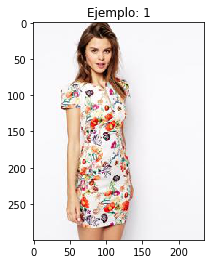

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve']


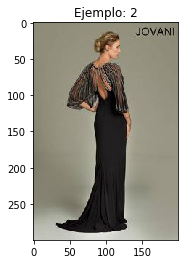

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'short_sleeve', 'solid']


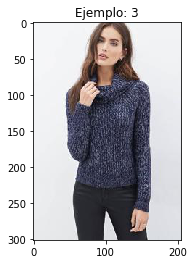

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'solid']


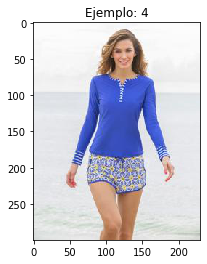

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'no_dress', 'no_neckline', 'sleeveless', 'solid']


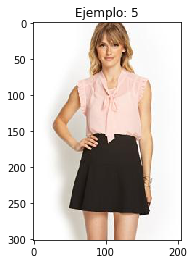

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'no_dress', 'solid', 'v_neckline']


In [36]:
# Ejemplos para la red DenseNet201
y_pred_vgg16 = vgg16_test_res[0]
display_examples(y_pred_vgg16)

In [33]:
# Calcula
## Número de veces que aparece un atributo en una predicción
## Número de veces en el que la predicción de un atributo se realiza de forma correcta
## Número de veces en el que la predicción de un atributo se realiza de forma incorrecta
def get_prediction_accuracy(y_true_df, y_pred, k=6):
    
    # Inicialización de los vectores
    times_predicted = [0] * NUM_CLASSES
    times_correctly_predicted = [0] * NUM_CLASSES
    times_incorrectly_predicted = [0] * NUM_CLASSES

    for index, row in y_true_df.iterrows():
        
        # Obtención de los verdaderos positivos
        true_possitives = np.where(row==1)

        # Obtención de los k valores con mayor probabilidad
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            
            # Clasificación
            times_predicted[p]+=1
            if p in true_possitives[0]:
                times_correctly_predicted[p]+=1
            else:
                times_incorrectly_predicted[p]+=1
    return times_predicted, times_correctly_predicted, times_incorrectly_predicted

In [34]:
# Construcción de la tabla de resultados a partir de la lista de listas de valores predichos por un modelo sobre la partición de test
def build_results_table(y_pred):

    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columna de frecuencia real
    frequency = y_true_df.sum().tolist()

    # Columna de frecuencia de predicción, Verdaderos positivos y Falsos positivos
    times_predicted, times_correctly_predicted, times_incorrectly_predicted = get_prediction_accuracy(y_true_df, y_pred)

    # Columnas de sensibilidad y precisión
    recall = [a/b for a,b in zip(times_correctly_predicted, frequency)]
    precission = [a/max(1,b) for a,b in zip(times_correctly_predicted, times_predicted)]

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia real' : frequency, 
         'Frecuencia predicción' : times_predicted, 'TP': times_correctly_predicted, 'FP' : times_incorrectly_predicted, 
         'Sensibilidad' : recall, 'Precisión' : precission}
    return pd.DataFrame(data=d)


In [35]:
build_results_table(y_pred_vgg16)

,Atributo,Tipo,Frecuencia real,Frecuencia predicción,TP,FP,Sensibilidad,Precisión
0,floral,Estampado,664,312,220,92,0.33,0.71
1,graphic,Estampado,668,114,79,35,0.12,0.69
2,striped,Estampado,292,264,203,61,0.70,0.77
3,embroidered,Estampado,338,0,0,0,0.00,0.00
4,pleated,Estampado,78,0,0,0,0.00,0.00
5,solid,Estampado,1898,2994,1873,1121,0.99,0.63
6,lattice,Estampado,62,0,0,0,0.00,0.00
7,long_sleeve,Tipo de manga,1243,970,831,139,0.67,0.86
8,short_sleeve,Tipo de manga,686,338,296,42,0.43,0.88
9,sleeveless,Tipo de manga,2071,2725,1976,749,0.95,0.73


A partir de la tabla anterior se puede observar que la mayor problemática a la hora de entrenar el modelo ha sido el _data imbalace_. Los atributos que aparecen con mayor frecuencia (tanto en las particiones de entrenamiento y validación, como en la de test) suelen predecirse con mayor frecuencia que los atributos minoritarios. Esto implica que atribotos como _leather_ o _faux_ no aparezcan en ninga predicción. Por otro lado llama la atención el bajo número de veces que el modelo predice atributos como _knit_ o _embroidered_. 

En una iteración posterior sobre estos modelos se podría contemplar aumentar el número de ejemplos de los atributos minoritarios en las particiones de entrenamiento y validación, o el empleo de alguna métrica como F1 a la hora de realizar el entrenamiento para solventar este problema. 

Por otro lado, en los casos en los que en una imagen aparecen varias prendas, se ha detectado que las anotaciones pertenecen a una de ellas mientras que el modelo parece predecir las de otra. Esto se puede apreciar en el ejemplo 4, en el que solo hay una diferencia en el conjunto de etiquetas. La etiqueta real es _floral_, que aplica al pantalón corto mientras que el modelo predice _solid_ que aplica a la prenda superior. 